# Imports and setup

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
import torch.optim as optim
import torchmetrics
import pandas as pd
import json

# If VSCode doesn't pick up this import, see answer here: 
# https://stackoverflow.com/questions/65252074/import-path-to-own-script-could-not-be-resolved-pylance-reportmissingimports
import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import * 

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", balance = True)
val_gen_dataset = CustomDataset("Generated", "validation", balance=True)
test_gen_dataset = CustomDataset("Generated", "test", balance=True)

# Extract the real data
train_real_dataset = CustomDataset("Real Life", "train", balance=True)
val_real_dataset = CustomDataset("Real Life", "validation", balance=True)
test_real_dataset = CustomDataset("Real Life", "test", balance=True)

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model to tune.

In [4]:
batch_size_choices = {100, 200} # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
dropout_rate_choices = {0.2, 0.5}
gamma_focal_loss_choices = {2, 5} # Choices for the gamma parameter in the focal loss
learning_rate = 0.001
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run
num_epochs = 1 # Since we only train on generated data, we can use a small number of epochs because we have around 300000 images plus the augmentation

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: mps


We can then go ahead and define the loss function we will be using. Because we will opt for a balanced focal loss instead of a regular cross entropy loss which gives more importance to the classes that are harder to classify. We thus implement the focal loss defined by the following formula:
$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.



Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [9]:
# Define the accuracy metrics
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

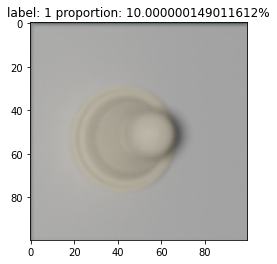

In [10]:
gen_train_loader = get_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for saving the metrics collected during training. We will plot these metrics later in the Results.ipynb file.

In [11]:
def save_metrics_to_json(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate):

    metrics = {
        "gen_training_losses": gen_training_losses,
        "gen_training_accs": gen_training_accs,
        "gen_training_f1s": gen_training_f1s,
        "gen_validation_losses": gen_validation_losses,
        "gen_validation_accs": gen_validation_accs,
        "gen_validation_f1s": gen_validation_f1s,
        "real_validation_losses": real_validation_losses,
        "real_validation_accs": real_validation_accs,
        "real_validation_f1s": real_validation_f1s,
        "gamma": gamma,
        "batch_size": batch_size,
        "dropout_rate": dropout_rate
    }

    with open("HP tuning results/" + "gamma_" + str(gamma) + "_batch_" + str(batch_size) + "_dropout_" + str(dropout_rate) + ".json", "w") as json_file:
        json.dump(metrics, json_file)

We can now define a training function we will call for each hyperparameter combination.

In [12]:
def train_BASE(gamma, dropout_rate, batch_size):
    # Define the data loaders accounting for the batch size
    train_loader = get_loader(train_gen_dataset, batch_size=batch_size)
    gen_val_loader = get_loader(val_gen_dataset, batch_size=batch_size)
    real_val_loader = get_loader(val_real_dataset, batch_size=batch_size)  

    # Define the new loss function (Taking into account gamma)
    focal_loss = torch.hub.load(
        'adeelh/pytorch-multi-class-focal-loss',
        model='FocalLoss',
        gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
        reduction='mean',
        force_reload=False,
        verbose = False
    ).to(DEVICE)

    basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)      
    opt = optim.Adam(basemodel.parameters(), lr=learning_rate)

    # To store the metrics through epochs
    gen_training_losses = []
    gen_training_accs = []
    gen_training_f1s = []
    gen_validation_losses = []
    gen_validation_accs = []
    gen_validation_f1s = []
    real_validation_losses = []
    real_validation_accs = []
    real_validation_f1s = []

    for epoch in range(num_epochs):
        
        # Train the model
        for iteration, (X_train_gen, y_train_gen) in tqdm(enumerate(train_loader)):
            
            # Set the model to training mode
            basemodel.train()

            # Move the data to the device
            X_train_gen = X_train_gen.to(DEVICE)
            y_train_gen = y_train_gen.to(DEVICE)

            # Forward pass
            y_train_pred_raw_gen = basemodel(X_train_gen)
            y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

            # Compute the loss
            loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

            # Compute the accuracy
            acc_train = accuracy(y_train_pred_gen, y_train_gen)
            f1_train = f1_score(y_train_pred_gen, y_train_gen)

            # Backward pass
            opt.zero_grad()
            loss_train.backward()
            opt.step()

            # Store the loss & accuracy
            gen_training_losses.append(loss_train.item())
            gen_training_accs.append(acc_train.item())
            gen_training_f1s.append(f1_train.item())
            
            # Check if the model should be validated
            if iteration == 0 or (iteration + 1) % n_validation == 0:
                
                # Set the model to evaluation mode
                basemodel.eval()
                
                # Disable gradient calculation
                with torch.no_grad():

                    # 1) Evaluate on the generated validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    gen_val_iter = iter(gen_val_loader)

                    # Iterate for n_validation_minibatches
                    for i in range(n_validation_minibatches):

                        # Get the next minibatch
                        X_val_gen, y_val_gen = next(gen_val_iter)
                            
                        # Move the data to the device
                        X_val_gen = X_val_gen.to(DEVICE)
                        y_val_gen = y_val_gen.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_gen = basemodel(X_val_gen)
                        y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                        weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                        loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                    # Compute the average metrics
                    acc_val_gen = acc_val_sum / n_validation_minibatches
                    loss_val_gen = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches

                    # 2) Repeat on the real validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    real_val_iter = iter(real_val_loader)

                    # Iterate for n_validation_minibatches
                    for i in range(n_validation_minibatches):

                        # Get the next minibatch
                        X_val_real, y_val_real = next(real_val_iter)
                            
                        # Move the data to the device
                        X_val_real = X_val_real.to(DEVICE)
                        y_val_real = y_val_real.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_real = basemodel(X_val_real)
                        y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                        weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                        loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                    # Compute the average metrics
                    acc_val_real = acc_val_sum / n_validation_minibatches
                    loss_val_real = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                    # Store all 6 metrics
                    gen_validation_losses.append(loss_val_gen.item())
                    gen_validation_accs.append(acc_val_gen.item())
                    gen_validation_f1s.append(weighted_f1_val_gen.item())
                    real_validation_losses.append(loss_val_real.item())
                    real_validation_accs.append(acc_val_real.item())
                    real_validation_f1s.append(weighted_f1_val_real.item())

                    # Print an update
                    print('----------------------------------------------------------------')
                    print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                    print(f'TRAINING => Loss: {loss_train}, Training accuracy: {acc_train}, Training weighted F1: {f1_train}')
                    print(f'GENERATED VALIDATION => Loss: {loss_val_gen}, Validation accuracy: {acc_val_gen}, Validation weighted F1: {weighted_f1_val_gen}')
                    print(f'REAL VALIDATION => Loss: {loss_val_real}, Validation accuracy: {acc_val_real}, Validation weighted F1: {weighted_f1_val_real}')
                    print('----------------------------------------------------------------')

        # Save the model every epoch as a checkpoint 
        torch.save(basemodel.state_dict(), f'./checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')
    
    # Plot and save the metrics
    save_metrics_to_json(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate)
    
    return basemodel

We also define an evaluate function to compare the best models obtained during training for each hyperparameter combination. The comparison is done on the real life validation set.

In [13]:
def evaluate(basemodel, batch_size):
    # Load the real validation dataset
    real_val_loader = get_loader(val_real_dataset, batch_size=batch_size)  

    # Evaluate the final real life validation accuracy
    # Set the model to evaluation mode
    basemodel.eval()
    acc_val_sum = 0

    # Create an iterator
    real_val_iter = iter(real_val_loader)

    # Disable gradient calculation
    with torch.no_grad():
        
        for i in range(n_final_validation_minibatches):

            # Get the next minibatch
            minibatch = next(real_val_iter, None)
            if minibatch is None:
                real_val_iter = iter(real_val_loader)
                minibatch = next(real_val_iter, None)
            X_val_real, y_val_real = minibatch

            # Move the data to the device
            X_val_real = X_val_real.to(DEVICE)
            y_val_real = y_val_real.to(DEVICE)

            # Forward pass
            y_val_pred_prob_real = basemodel(X_val_real)
            y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

            # Compute the metrics
            acc_val_sum += accuracy(y_val_pred_real, y_val_real)

    # Compute the average accuracy
    final_real_val_acc = acc_val_sum / n_final_validation_minibatches

    return final_real_val_acc

We can now proceed to train our model on the generated dataset:

In [14]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Dropout Rate", "Batch Size", "Final validation accuracy"])

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        for batch_size in batch_size_choices:
            
            # Train the model
            basemodel = train_BASE(gamma, dropout_rate, batch_size)

            # Evaluate the model on the real validation set 
            final_real_val_acc = evaluate(basemodel, batch_size)  

            # Create a row to add to the dataframe
            row = [gamma, batch_size, dropout_rate, final_real_val_acc.cpu().item()]
            
            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model is None or best_acc < final_real_val_acc:
                best_model = basemodel
                best_acc = final_real_val_acc
                torch.save(basemodel.state_dict(), f'./best_model.ckpt')

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)    

0it [00:00, ?it/s]/Users/enzobenoit-jeannin/Documents/GitHub/RecogniChess/myenv/lib/python3.9/site-packages/torchmetrics/functional/classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp
1it [00:03,  3.37s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1893675327301025, Training accuracy: 0.03999999910593033, Training weighted F1: 0.0293600894510746
GENERATED VALIDATION => Loss: 2.022036552429199, Validation accuracy: 0.18000000715255737, Validation weighted F1: 0.10656370222568512
REAL VALIDATION => Loss: 2.0938830375671387, Validation accuracy: 0.15000000596046448, Validation weighted F1: 0.09172789752483368
----------------------------------------------------------------


10it [00:08,  1.11it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.4913261830806732, Training accuracy: 0.7450000047683716, Training weighted F1: 0.7173953056335449
GENERATED VALIDATION => Loss: 0.4248589873313904, Validation accuracy: 0.7224999666213989, Validation weighted F1: 0.6945870518684387
REAL VALIDATION => Loss: 1.3525692224502563, Validation accuracy: 0.44749999046325684, Validation weighted F1: 0.38767075538635254
----------------------------------------------------------------


20it [00:13,  1.22it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.1713673174381256, Training accuracy: 0.875, Training weighted F1: 0.8710308074951172
GENERATED VALIDATION => Loss: 0.17968784272670746, Validation accuracy: 0.8474999666213989, Validation weighted F1: 0.8397862911224365
REAL VALIDATION => Loss: 1.8781938552856445, Validation accuracy: 0.4024999737739563, Validation weighted F1: 0.36951732635498047
----------------------------------------------------------------


30it [00:18,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.14173439145088196, Training accuracy: 0.8899999856948853, Training weighted F1: 0.8868579864501953
GENERATED VALIDATION => Loss: 0.07025428861379623, Validation accuracy: 0.9450000524520874, Validation weighted F1: 0.9420223236083984
REAL VALIDATION => Loss: 1.9437589645385742, Validation accuracy: 0.4325000047683716, Validation weighted F1: 0.3964698612689972
----------------------------------------------------------------


40it [00:23,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.08699311316013336, Training accuracy: 0.9300000667572021, Training weighted F1: 0.9285304546356201
GENERATED VALIDATION => Loss: 0.05751175805926323, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9494813680648804
REAL VALIDATION => Loss: 1.4273364543914795, Validation accuracy: 0.48750001192092896, Validation weighted F1: 0.46483373641967773
----------------------------------------------------------------


50it [00:28,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.0698012039065361, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9598383903503418
GENERATED VALIDATION => Loss: 0.03517693281173706, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9677470326423645
REAL VALIDATION => Loss: 1.295423150062561, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48719412088394165
----------------------------------------------------------------


60it [00:32,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.03904257342219353, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9598768949508667
GENERATED VALIDATION => Loss: 0.0312681645154953, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9700533151626587
REAL VALIDATION => Loss: 1.5337598323822021, Validation accuracy: 0.49500003457069397, Validation weighted F1: 0.4937233328819275
----------------------------------------------------------------


70it [00:37,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.0485859140753746, Training accuracy: 0.9350000023841858, Training weighted F1: 0.9360077381134033
GENERATED VALIDATION => Loss: 0.03796295449137688, Validation accuracy: 0.9624999761581421, Validation weighted F1: 0.9627269506454468
REAL VALIDATION => Loss: 1.4712855815887451, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5119012594223022
----------------------------------------------------------------


80it [00:42,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.05048789083957672, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9558375477790833
GENERATED VALIDATION => Loss: 0.02899741195142269, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9651684761047363
REAL VALIDATION => Loss: 1.5567255020141602, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.43686386942863464
----------------------------------------------------------------


90it [00:46,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.04359643906354904, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9693036675453186
GENERATED VALIDATION => Loss: 0.02640191651880741, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9675758481025696
REAL VALIDATION => Loss: 1.71897554397583, Validation accuracy: 0.45749998092651367, Validation weighted F1: 0.44585198163986206
----------------------------------------------------------------


100it [00:51,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.029742522165179253, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802736043930054
GENERATED VALIDATION => Loss: 0.011133348569273949, Validation accuracy: 0.9899999499320984, Validation weighted F1: 0.9900481700897217
REAL VALIDATION => Loss: 1.409883737564087, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4972560405731201
----------------------------------------------------------------


110it [00:55,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.02006758563220501, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9903662204742432
GENERATED VALIDATION => Loss: 0.011925592087209225, Validation accuracy: 0.9899999499320984, Validation weighted F1: 0.98995041847229
REAL VALIDATION => Loss: 1.8083075284957886, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4192628264427185
----------------------------------------------------------------


120it [01:00,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.012057794257998466, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800013303756714
GENERATED VALIDATION => Loss: 0.013107060454785824, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850304126739502
REAL VALIDATION => Loss: 1.5523500442504883, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5045775175094604
----------------------------------------------------------------


130it [01:04,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.015969518572092056, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800760746002197
GENERATED VALIDATION => Loss: 0.012977564707398415, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850775003433228
REAL VALIDATION => Loss: 1.548058032989502, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.5158106088638306
----------------------------------------------------------------


140it [01:09,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.01785273104906082, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9802336096763611
GENERATED VALIDATION => Loss: 0.026989560574293137, Validation accuracy: 0.9725000262260437, Validation weighted F1: 0.9720423221588135
REAL VALIDATION => Loss: 1.6182990074157715, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.47557997703552246
----------------------------------------------------------------


150it [01:14,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.030640238896012306, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9680310487747192
GENERATED VALIDATION => Loss: 0.02898264303803444, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9675211906433105
REAL VALIDATION => Loss: 1.4158681631088257, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.496384859085083
----------------------------------------------------------------


160it [01:18,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.020721307024359703, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9750835299491882
GENERATED VALIDATION => Loss: 0.02486344799399376, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9772826433181763
REAL VALIDATION => Loss: 1.291051983833313, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.5213118195533752
----------------------------------------------------------------


170it [01:23,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.013149488717317581, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989968478679657
GENERATED VALIDATION => Loss: 0.023741349577903748, Validation accuracy: 0.9725000262260437, Validation weighted F1: 0.9722501039505005
REAL VALIDATION => Loss: 1.6157339811325073, Validation accuracy: 0.4925000071525574, Validation weighted F1: 0.46947363018989563
----------------------------------------------------------------


180it [01:27,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.035213831812143326, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9750249981880188
GENERATED VALIDATION => Loss: 0.018561644479632378, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9770418405532837
REAL VALIDATION => Loss: 1.803185224533081, Validation accuracy: 0.42250001430511475, Validation weighted F1: 0.39308983087539673
----------------------------------------------------------------


190it [01:32,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.02646702155470848, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9703834652900696
GENERATED VALIDATION => Loss: 0.011799728497862816, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848555326461792
REAL VALIDATION => Loss: 1.6382277011871338, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.4217885136604309
----------------------------------------------------------------


200it [01:36,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.020974529907107353, Training accuracy: 0.98499995470047, Training weighted F1: 0.9849274158477783
GENERATED VALIDATION => Loss: 0.029624255374073982, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9751348495483398
REAL VALIDATION => Loss: 1.5783491134643555, Validation accuracy: 0.48750001192092896, Validation weighted F1: 0.4762592315673828
----------------------------------------------------------------


210it [01:41,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.014197371900081635, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900161027908325
GENERATED VALIDATION => Loss: 0.014242113567888737, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849905967712402
REAL VALIDATION => Loss: 1.788119912147522, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4253023862838745
----------------------------------------------------------------


220it [01:45,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.026460669934749603, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9850731492042542
GENERATED VALIDATION => Loss: 0.01113586314022541, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9873508214950562
REAL VALIDATION => Loss: 1.4697656631469727, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4948975741863251
----------------------------------------------------------------


230it [01:50,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.02477979101240635, Training accuracy: 0.98499995470047, Training weighted F1: 0.9849032759666443
GENERATED VALIDATION => Loss: 0.007612293586134911, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900157451629639
REAL VALIDATION => Loss: 1.8075006008148193, Validation accuracy: 0.45249998569488525, Validation weighted F1: 0.43288594484329224
----------------------------------------------------------------


240it [01:54,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.030918395146727562, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9697681665420532
GENERATED VALIDATION => Loss: 0.016001403331756592, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9774773120880127
REAL VALIDATION => Loss: 1.190979242324829, Validation accuracy: 0.5575000047683716, Validation weighted F1: 0.5409071445465088
----------------------------------------------------------------


250it [01:59,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.015451204031705856, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9743471145629883
GENERATED VALIDATION => Loss: 0.02825208380818367, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9826295375823975
REAL VALIDATION => Loss: 1.735558032989502, Validation accuracy: 0.4724999964237213, Validation weighted F1: 0.45392030477523804
----------------------------------------------------------------


260it [02:03,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.005931728985160589, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900373220443726
GENERATED VALIDATION => Loss: 0.008826397359371185, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9876707792282104
REAL VALIDATION => Loss: 1.3570233583450317, Validation accuracy: 0.5274999737739563, Validation weighted F1: 0.5147010087966919
----------------------------------------------------------------


270it [02:08,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.00891890749335289, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899999499320984
GENERATED VALIDATION => Loss: 0.006045361515134573, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949348568916321
REAL VALIDATION => Loss: 1.345564365386963, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5330039858818054
----------------------------------------------------------------


280it [02:12,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.021351926028728485, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900344610214233
GENERATED VALIDATION => Loss: 0.012821631506085396, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9875534772872925
REAL VALIDATION => Loss: 1.8660809993743896, Validation accuracy: 0.5074999928474426, Validation weighted F1: 0.480284720659256
----------------------------------------------------------------


290it [02:17,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.014400710351765156, Training accuracy: 0.98499995470047, Training weighted F1: 0.9849966764450073
GENERATED VALIDATION => Loss: 0.006187635473906994, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949707388877869
REAL VALIDATION => Loss: 1.5322213172912598, Validation accuracy: 0.5750000476837158, Validation weighted F1: 0.5454725027084351
----------------------------------------------------------------


300it [02:22,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.01718197949230671, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9743874073028564
GENERATED VALIDATION => Loss: 0.01885630562901497, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850524663925171
REAL VALIDATION => Loss: 1.2475736141204834, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5557901859283447
----------------------------------------------------------------


310it [02:26,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.015715349465608597, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800045490264893
GENERATED VALIDATION => Loss: 0.006489133927971125, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924951791763306
REAL VALIDATION => Loss: 1.5927131175994873, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.5074843168258667
----------------------------------------------------------------


320it [02:31,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.016265081241726875, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797526597976685
GENERATED VALIDATION => Loss: 0.031208308413624763, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.980341911315918
REAL VALIDATION => Loss: 1.1375527381896973, Validation accuracy: 0.5824999809265137, Validation weighted F1: 0.5668920278549194
----------------------------------------------------------------


330it [02:35,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.006306846160441637, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899787902832031
GENERATED VALIDATION => Loss: 0.00707303686067462, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898342490196228
REAL VALIDATION => Loss: 1.775743842124939, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.48815545439720154
----------------------------------------------------------------


340it [02:40,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.003544838400557637, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.007730135694146156, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9878098964691162
REAL VALIDATION => Loss: 1.7862787246704102, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.503730058670044
----------------------------------------------------------------


350it [02:44,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.027025965973734856, Training accuracy: 0.9649999141693115, Training weighted F1: 0.9640376567840576
GENERATED VALIDATION => Loss: 0.018320703878998756, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850951433181763
REAL VALIDATION => Loss: 1.8273791074752808, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.46695104241371155
----------------------------------------------------------------


360it [02:49,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.016571257263422012, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9804097414016724
GENERATED VALIDATION => Loss: 0.007526970934122801, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.997522234916687
REAL VALIDATION => Loss: 1.7128913402557373, Validation accuracy: 0.5625, Validation weighted F1: 0.5398048162460327
----------------------------------------------------------------


370it [02:53,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.05389467254281044, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699774384498596
GENERATED VALIDATION => Loss: 0.01708950474858284, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9774395227432251
REAL VALIDATION => Loss: 1.7465405464172363, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5000646710395813
----------------------------------------------------------------


380it [02:58,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.01307338010519743, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798883199691772
GENERATED VALIDATION => Loss: 0.012870624661445618, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9876750707626343
REAL VALIDATION => Loss: 1.6320164203643799, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4877875745296478
----------------------------------------------------------------


390it [03:02,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.016155850142240524, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849395155906677
GENERATED VALIDATION => Loss: 0.005860228091478348, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925125241279602
REAL VALIDATION => Loss: 1.7738721370697021, Validation accuracy: 0.565000057220459, Validation weighted F1: 0.5403031706809998
----------------------------------------------------------------


400it [03:07,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.0026656254194676876, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.014100335538387299, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9874985814094543
REAL VALIDATION => Loss: 1.355289101600647, Validation accuracy: 0.5325000286102295, Validation weighted F1: 0.5189909934997559
----------------------------------------------------------------


410it [03:11,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.004856014624238014, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950225353240967
GENERATED VALIDATION => Loss: 0.004688805900514126, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950307011604309
REAL VALIDATION => Loss: 1.1465706825256348, Validation accuracy: 0.5674999952316284, Validation weighted F1: 0.5612697601318359
----------------------------------------------------------------


420it [03:16,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.007838718593120575, Training accuracy: 0.9949999451637268, Training weighted F1: 0.9949626922607422
GENERATED VALIDATION => Loss: 0.00909285619854927, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950076341629028
REAL VALIDATION => Loss: 1.6219310760498047, Validation accuracy: 0.5024999976158142, Validation weighted F1: 0.4952253997325897
----------------------------------------------------------------


430it [03:20,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.02012551762163639, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9851264357566833
GENERATED VALIDATION => Loss: 0.008715914562344551, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9876152873039246
REAL VALIDATION => Loss: 1.480423927307129, Validation accuracy: 0.5324999690055847, Validation weighted F1: 0.514380931854248
----------------------------------------------------------------


440it [03:25,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.006844316143542528, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950250387191772
GENERATED VALIDATION => Loss: 0.008959840051829815, Validation accuracy: 0.9899999499320984, Validation weighted F1: 0.9900760650634766
REAL VALIDATION => Loss: 1.3980942964553833, Validation accuracy: 0.5875000357627869, Validation weighted F1: 0.577985405921936
----------------------------------------------------------------


450it [03:29,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.006977225188165903, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899262189865112
GENERATED VALIDATION => Loss: 0.010363996028900146, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9875578880310059
REAL VALIDATION => Loss: 1.8968679904937744, Validation accuracy: 0.5274999737739563, Validation weighted F1: 0.5099974274635315
----------------------------------------------------------------


460it [03:34,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.011831037700176239, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9749573469161987
GENERATED VALIDATION => Loss: 0.01616591401398182, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9801950454711914
REAL VALIDATION => Loss: 1.6081125736236572, Validation accuracy: 0.5475000143051147, Validation weighted F1: 0.5267057418823242
----------------------------------------------------------------


470it [03:38,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.015003778971731663, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900412559509277
GENERATED VALIDATION => Loss: 0.005167708732187748, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900628328323364
REAL VALIDATION => Loss: 1.9993051290512085, Validation accuracy: 0.5074999928474426, Validation weighted F1: 0.4790809750556946
----------------------------------------------------------------


480it [03:43,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.00255973800085485, Training accuracy: 0.9949999451637268, Training weighted F1: 0.9949445128440857
GENERATED VALIDATION => Loss: 0.007170877419412136, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924737215042114
REAL VALIDATION => Loss: 1.7096977233886719, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.48928704857826233
----------------------------------------------------------------


490it [03:47,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.006385399494320154, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899835586547852
GENERATED VALIDATION => Loss: 0.015299247577786446, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9876734018325806
REAL VALIDATION => Loss: 1.4904494285583496, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5690984725952148
----------------------------------------------------------------


500it [03:52,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.004576723091304302, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950116872787476
GENERATED VALIDATION => Loss: 0.013198185712099075, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850243330001831
REAL VALIDATION => Loss: 1.5775234699249268, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5121628046035767
----------------------------------------------------------------


510it [03:56,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.020214064046740532, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899841547012329
GENERATED VALIDATION => Loss: 0.006668226793408394, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924750328063965
REAL VALIDATION => Loss: 1.5026841163635254, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.531889796257019
----------------------------------------------------------------


520it [04:01,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.01045637484639883, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799485206604004
GENERATED VALIDATION => Loss: 0.00944672804325819, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9876207113265991
REAL VALIDATION => Loss: 1.6918971538543701, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.44135862588882446
----------------------------------------------------------------


530it [04:05,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.005228771828114986, Training accuracy: 0.9949999451637268, Training weighted F1: 0.9950370192527771
GENERATED VALIDATION => Loss: 0.010269753634929657, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9874456524848938
REAL VALIDATION => Loss: 1.4330110549926758, Validation accuracy: 0.5024999976158142, Validation weighted F1: 0.4948671758174896
----------------------------------------------------------------


540it [04:10,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.009722237475216389, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9848541021347046
GENERATED VALIDATION => Loss: 0.026993080973625183, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799758195877075
REAL VALIDATION => Loss: 1.6538746356964111, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5248608589172363
----------------------------------------------------------------


550it [04:14,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.03300075605511665, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9496359825134277
GENERATED VALIDATION => Loss: 0.021261874586343765, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.977411150932312
REAL VALIDATION => Loss: 1.566558599472046, Validation accuracy: 0.5374999642372131, Validation weighted F1: 0.4976162910461426
----------------------------------------------------------------


560it [04:19,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.006866170093417168, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899846911430359
GENERATED VALIDATION => Loss: 0.0026076016947627068, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.54372239112854, Validation accuracy: 0.5550000667572021, Validation weighted F1: 0.5201771855354309
----------------------------------------------------------------


570it [04:23,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.006288847886025906, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9901843070983887
GENERATED VALIDATION => Loss: 0.013343199156224728, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.986964762210846
REAL VALIDATION => Loss: 1.819109320640564, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5017507076263428
----------------------------------------------------------------


580it [04:28,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.00598121527582407, Training accuracy: 0.9900000691413879, Training weighted F1: 0.9899524450302124
GENERATED VALIDATION => Loss: 0.009518349543213844, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.990166187286377
REAL VALIDATION => Loss: 1.7863069772720337, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4618104100227356
----------------------------------------------------------------


590it [04:32,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.0164934229105711, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9850342273712158
GENERATED VALIDATION => Loss: 0.0031059759203344584, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9975340366363525
REAL VALIDATION => Loss: 1.519502878189087, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5472121238708496
----------------------------------------------------------------


600it [04:37,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.007644936442375183, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9803193807601929
GENERATED VALIDATION => Loss: 0.004815140273422003, Validation accuracy: 0.9925000667572021, Validation weighted F1: 0.9925178289413452
REAL VALIDATION => Loss: 1.711151123046875, Validation accuracy: 0.5274999737739563, Validation weighted F1: 0.4995740056037903
----------------------------------------------------------------


610it [04:41,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.007646563928574324, Training accuracy: 0.98499995470047, Training weighted F1: 0.9850435853004456
GENERATED VALIDATION => Loss: 0.009941723197698593, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950088262557983
REAL VALIDATION => Loss: 1.7217528820037842, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5185140371322632
----------------------------------------------------------------


620it [04:46,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.005491046234965324, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899329543113708
GENERATED VALIDATION => Loss: 0.0024007828906178474, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9974915981292725
REAL VALIDATION => Loss: 1.9338113069534302, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.4953232407569885
----------------------------------------------------------------


630it [04:50,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.006020881235599518, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899245500564575
GENERATED VALIDATION => Loss: 0.009234296157956123, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847626686096191
REAL VALIDATION => Loss: 2.3055620193481445, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.4984237849712372
----------------------------------------------------------------


640it [04:55,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.003777068108320236, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.016808662563562393, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899857044219971
REAL VALIDATION => Loss: 1.9624552726745605, Validation accuracy: 0.47749996185302734, Validation weighted F1: 0.4469933807849884
----------------------------------------------------------------


650it [05:00,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.011440078727900982, Training accuracy: 0.9900000095367432, Training weighted F1: 0.990019679069519
GENERATED VALIDATION => Loss: 0.002514834748581052, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9975060224533081
REAL VALIDATION => Loss: 1.590304970741272, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5412144660949707
----------------------------------------------------------------


660it [05:04,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.006060461979359388, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899441599845886
GENERATED VALIDATION => Loss: 0.005671181716024876, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949771165847778
REAL VALIDATION => Loss: 1.7032010555267334, Validation accuracy: 0.5674999952316284, Validation weighted F1: 0.5465617179870605
----------------------------------------------------------------


670it [05:09,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.007444532122462988, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9904911518096924
GENERATED VALIDATION => Loss: 0.006726569030433893, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949783086776733
REAL VALIDATION => Loss: 1.9464375972747803, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5579584240913391
----------------------------------------------------------------


680it [05:13,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.0031758020631968975, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950056076049805
GENERATED VALIDATION => Loss: 0.008807923644781113, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900005459785461
REAL VALIDATION => Loss: 1.8465344905853271, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.531537652015686
----------------------------------------------------------------


690it [05:17,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.007505626417696476, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849262833595276
GENERATED VALIDATION => Loss: 0.007559996098279953, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899203777313232
REAL VALIDATION => Loss: 1.9918084144592285, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.4783434569835663
----------------------------------------------------------------


700it [05:22,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.007566902320832014, Training accuracy: 0.9850000143051147, Training weighted F1: 0.985149621963501
GENERATED VALIDATION => Loss: 0.005803047679364681, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899728298187256
REAL VALIDATION => Loss: 1.7081036567687988, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5393369197845459
----------------------------------------------------------------


710it [05:26,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.009239181876182556, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900341629981995
GENERATED VALIDATION => Loss: 0.011667629703879356, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9875679612159729
REAL VALIDATION => Loss: 1.9513001441955566, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4832705855369568
----------------------------------------------------------------


720it [05:31,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.009613743983209133, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899170398712158
GENERATED VALIDATION => Loss: 0.02206234261393547, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9777412414550781
REAL VALIDATION => Loss: 1.9497380256652832, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5035734176635742
----------------------------------------------------------------


730it [05:35,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.001716372324153781, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.02481268346309662, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9777243137359619
REAL VALIDATION => Loss: 1.7342000007629395, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49333998560905457
----------------------------------------------------------------


740it [05:40,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.005009387619793415, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901019334793091
GENERATED VALIDATION => Loss: 0.004212421365082264, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898735880851746
REAL VALIDATION => Loss: 1.8679399490356445, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5404528379440308
----------------------------------------------------------------


750it [05:44,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.018783558160066605, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800065755844116
GENERATED VALIDATION => Loss: 0.01574910432100296, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849569797515869
REAL VALIDATION => Loss: 2.009326934814453, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.4979444146156311
----------------------------------------------------------------


760it [05:49,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.01590139791369438, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9851123690605164
GENERATED VALIDATION => Loss: 0.011355601251125336, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924532175064087
REAL VALIDATION => Loss: 2.317340850830078, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4544292390346527
----------------------------------------------------------------


770it [05:53,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.015274642035365105, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800676107406616
GENERATED VALIDATION => Loss: 0.007836796343326569, Validation accuracy: 0.9875000715255737, Validation weighted F1: 0.9875973463058472
REAL VALIDATION => Loss: 2.1698179244995117, Validation accuracy: 0.5, Validation weighted F1: 0.4936365783214569
----------------------------------------------------------------


780it [05:57,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.003433756995946169, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950104355812073
GENERATED VALIDATION => Loss: 0.023376425728201866, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900467395782471
REAL VALIDATION => Loss: 1.9505136013031006, Validation accuracy: 0.565000057220459, Validation weighted F1: 0.5434967279434204
----------------------------------------------------------------


790it [06:02,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.005137874744832516, Training accuracy: 0.98499995470047, Training weighted F1: 0.9849870204925537
GENERATED VALIDATION => Loss: 0.005828837864100933, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925370216369629
REAL VALIDATION => Loss: 2.102735757827759, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.565202534198761
----------------------------------------------------------------


800it [06:06,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.004083211533725262, Training accuracy: 0.9949999451637268, Training weighted F1: 0.994949460029602
GENERATED VALIDATION => Loss: 0.005342856049537659, Validation accuracy: 0.9924999475479126, Validation weighted F1: 0.9925014972686768
REAL VALIDATION => Loss: 1.558929204940796, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5441648960113525
----------------------------------------------------------------


810it [06:11,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.0028085457161068916, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.009202606044709682, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9875178337097168
REAL VALIDATION => Loss: 2.1965160369873047, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5281637907028198
----------------------------------------------------------------


820it [06:15,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.013234883546829224, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799745082855225
GENERATED VALIDATION => Loss: 0.004021878354251385, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924800395965576
REAL VALIDATION => Loss: 2.0285234451293945, Validation accuracy: 0.5724999904632568, Validation weighted F1: 0.542663037776947
----------------------------------------------------------------


830it [06:19,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.019454916939139366, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9747710227966309
GENERATED VALIDATION => Loss: 0.012039639055728912, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9778784513473511
REAL VALIDATION => Loss: 1.936360239982605, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5040037631988525
----------------------------------------------------------------


840it [06:24,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.005705830175429583, Training accuracy: 0.9850000143051147, Training weighted F1: 0.985008180141449
GENERATED VALIDATION => Loss: 0.011598039418458939, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850591421127319
REAL VALIDATION => Loss: 1.5418694019317627, Validation accuracy: 0.5924999713897705, Validation weighted F1: 0.5774756073951721
----------------------------------------------------------------


850it [06:28,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.004120456520467997, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950328469276428
GENERATED VALIDATION => Loss: 0.004406134597957134, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950304627418518
REAL VALIDATION => Loss: 1.9260082244873047, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.5043493509292603
----------------------------------------------------------------


860it [06:33,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.015210255980491638, Training accuracy: 0.98499995470047, Training weighted F1: 0.9849510192871094
GENERATED VALIDATION => Loss: 0.0040337033569812775, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899035692214966
REAL VALIDATION => Loss: 2.1590211391448975, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5003738403320312
----------------------------------------------------------------


870it [06:37,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.003644791664555669, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899474382400513
GENERATED VALIDATION => Loss: 0.0047485362738370895, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900436997413635
REAL VALIDATION => Loss: 2.094489812850952, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.4811917841434479
----------------------------------------------------------------


880it [06:41,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.01342723798006773, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9848021268844604
GENERATED VALIDATION => Loss: 0.011671822518110275, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924670457839966
REAL VALIDATION => Loss: 1.8166685104370117, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5427229404449463
----------------------------------------------------------------


890it [06:46,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.001155166421085596, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.003337777452543378, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925073981285095
REAL VALIDATION => Loss: 2.2144298553466797, Validation accuracy: 0.5024999976158142, Validation weighted F1: 0.48480626940727234
----------------------------------------------------------------


900it [06:50,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [900]
TRAINING => Loss: 0.0029513889458030462, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950000047683716
GENERATED VALIDATION => Loss: 0.005161503795534372, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950096607208252
REAL VALIDATION => Loss: 2.4575653076171875, Validation accuracy: 0.5225000381469727, Validation weighted F1: 0.5082470178604126
----------------------------------------------------------------


910it [06:55,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [910]
TRAINING => Loss: 0.005598671268671751, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950066208839417
GENERATED VALIDATION => Loss: 0.016214419156312943, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848830699920654
REAL VALIDATION => Loss: 2.0918660163879395, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.5111936926841736
----------------------------------------------------------------


920it [06:59,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [920]
TRAINING => Loss: 0.009279029443860054, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.008329068310558796, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899681806564331
REAL VALIDATION => Loss: 2.0587191581726074, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.47202011942863464
----------------------------------------------------------------


930it [07:04,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [930]
TRAINING => Loss: 0.013838544487953186, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899757504463196
GENERATED VALIDATION => Loss: 0.02306993305683136, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9822202920913696
REAL VALIDATION => Loss: 2.9095070362091064, Validation accuracy: 0.41750001907348633, Validation weighted F1: 0.3899843990802765
----------------------------------------------------------------


940it [07:08,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [940]
TRAINING => Loss: 0.020588617771863937, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9851174354553223
GENERATED VALIDATION => Loss: 0.003655213164165616, Validation accuracy: 0.997499942779541, Validation weighted F1: 0.9974933862686157
REAL VALIDATION => Loss: 2.3893632888793945, Validation accuracy: 0.47749999165534973, Validation weighted F1: 0.44082948565483093
----------------------------------------------------------------


950it [07:12,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [950]
TRAINING => Loss: 0.042377617210149765, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9611510038375854
GENERATED VALIDATION => Loss: 0.01463613286614418, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9875217080116272
REAL VALIDATION => Loss: 1.80211341381073, Validation accuracy: 0.6075000166893005, Validation weighted F1: 0.5845843553543091
----------------------------------------------------------------


960it [07:17,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [960]
TRAINING => Loss: 0.011927179992198944, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9750927686691284
GENERATED VALIDATION => Loss: 0.003263510763645172, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9975110292434692
REAL VALIDATION => Loss: 2.1778318881988525, Validation accuracy: 0.5074999928474426, Validation weighted F1: 0.49179595708847046
----------------------------------------------------------------


970it [07:21,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [970]
TRAINING => Loss: 0.00812743790447712, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900131225585938
GENERATED VALIDATION => Loss: 0.005978235509246588, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994978666305542
REAL VALIDATION => Loss: 1.790513515472412, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5358532667160034
----------------------------------------------------------------


980it [07:26,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [980]
TRAINING => Loss: 0.004309114068746567, Training accuracy: 0.9950000047683716, Training weighted F1: 0.994975745677948
GENERATED VALIDATION => Loss: 0.03465898334980011, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9770326614379883
REAL VALIDATION => Loss: 1.9440782070159912, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5293722748756409
----------------------------------------------------------------


990it [07:30,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [990]
TRAINING => Loss: 0.01505323126912117, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9808581471443176
GENERATED VALIDATION => Loss: 0.0030216178856790066, Validation accuracy: 0.997499942779541, Validation weighted F1: 0.9975021481513977
REAL VALIDATION => Loss: 1.6367967128753662, Validation accuracy: 0.5374999642372131, Validation weighted F1: 0.518859326839447
----------------------------------------------------------------


1000it [07:35,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1000]
TRAINING => Loss: 0.0077637736685574055, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9848551750183105
GENERATED VALIDATION => Loss: 0.0012792480411008, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.4238719940185547, Validation accuracy: 0.4724999666213989, Validation weighted F1: 0.4528384208679199
----------------------------------------------------------------


1010it [07:39,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1010]
TRAINING => Loss: 0.0022631383035331964, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.019656062126159668, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950105547904968
REAL VALIDATION => Loss: 1.8411343097686768, Validation accuracy: 0.5824999809265137, Validation weighted F1: 0.5565749406814575
----------------------------------------------------------------


1020it [07:43,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1020]
TRAINING => Loss: 0.020856469869613647, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800699353218079
GENERATED VALIDATION => Loss: 0.017370305955410004, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850499629974365
REAL VALIDATION => Loss: 2.1465916633605957, Validation accuracy: 0.5024999976158142, Validation weighted F1: 0.48126688599586487
----------------------------------------------------------------


1030it [07:48,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1030]
TRAINING => Loss: 0.001228763023391366, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.006501735188066959, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9902026653289795
REAL VALIDATION => Loss: 1.9540352821350098, Validation accuracy: 0.48750001192092896, Validation weighted F1: 0.46652132272720337
----------------------------------------------------------------


1040it [07:52,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1040]
TRAINING => Loss: 0.0032666665501892567, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950138330459595
GENERATED VALIDATION => Loss: 0.02414708212018013, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847452044487
REAL VALIDATION => Loss: 2.102808952331543, Validation accuracy: 0.5175000429153442, Validation weighted F1: 0.49430787563323975
----------------------------------------------------------------


1050it [07:57,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1050]
TRAINING => Loss: 0.005456428974866867, Training accuracy: 0.9949999451637268, Training weighted F1: 0.9950358867645264
GENERATED VALIDATION => Loss: 0.010441854596138, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900271892547607
REAL VALIDATION => Loss: 1.833250641822815, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.536102294921875
----------------------------------------------------------------


1060it [08:01,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1060]
TRAINING => Loss: 0.010059162974357605, Training accuracy: 0.9850000739097595, Training weighted F1: 0.9847346544265747
GENERATED VALIDATION => Loss: 0.0157175175845623, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9875556230545044
REAL VALIDATION => Loss: 1.9963743686676025, Validation accuracy: 0.5774999856948853, Validation weighted F1: 0.5407534837722778
----------------------------------------------------------------


1070it [08:06,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1070]
TRAINING => Loss: 0.015580902807414532, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899918437004089
GENERATED VALIDATION => Loss: 0.0030825315043330193, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950112104415894
REAL VALIDATION => Loss: 2.1867923736572266, Validation accuracy: 0.4674999713897705, Validation weighted F1: 0.46323361992836
----------------------------------------------------------------


1080it [08:10,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1080]
TRAINING => Loss: 0.01816823147237301, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849675893783569
GENERATED VALIDATION => Loss: 0.016573455184698105, Validation accuracy: 0.9924999475479126, Validation weighted F1: 0.992509126663208
REAL VALIDATION => Loss: 2.5330591201782227, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.48032355308532715
----------------------------------------------------------------


1090it [08:14,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1090]
TRAINING => Loss: 0.007779376115649939, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898701310157776
GENERATED VALIDATION => Loss: 0.02354693040251732, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9875482320785522
REAL VALIDATION => Loss: 1.9112422466278076, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.4976600408554077
----------------------------------------------------------------


1100it [08:19,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1100]
TRAINING => Loss: 0.0029807297978550196, Training accuracy: 0.9949999451637268, Training weighted F1: 0.994986891746521
GENERATED VALIDATION => Loss: 0.0028576040640473366, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.997523844242096
REAL VALIDATION => Loss: 1.7483477592468262, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.5088910460472107
----------------------------------------------------------------


1110it [08:23,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1110]
TRAINING => Loss: 0.030291013419628143, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699057340621948
GENERATED VALIDATION => Loss: 0.004410020541399717, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949986338615417
REAL VALIDATION => Loss: 2.205840587615967, Validation accuracy: 0.47749999165534973, Validation weighted F1: 0.44487977027893066
----------------------------------------------------------------


1120it [08:28,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1120]
TRAINING => Loss: 0.006144226528704166, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900329113006592
GENERATED VALIDATION => Loss: 0.019651610404253006, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849492311477661
REAL VALIDATION => Loss: 1.6114420890808105, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.5254190564155579
----------------------------------------------------------------


1130it [08:32,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1130]
TRAINING => Loss: 0.005173147656023502, Training accuracy: 0.9949999451637268, Training weighted F1: 0.995025098323822
GENERATED VALIDATION => Loss: 0.003931199200451374, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950341582298279
REAL VALIDATION => Loss: 1.8529231548309326, Validation accuracy: 0.5649999380111694, Validation weighted F1: 0.5341655611991882
----------------------------------------------------------------


1140it [08:37,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1140]
TRAINING => Loss: 0.007582865655422211, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899970889091492
GENERATED VALIDATION => Loss: 0.009720712900161743, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900128841400146
REAL VALIDATION => Loss: 1.5088216066360474, Validation accuracy: 0.5925000309944153, Validation weighted F1: 0.5757700204849243
----------------------------------------------------------------


1150it [08:41,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1150]
TRAINING => Loss: 0.004813666921108961, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898678064346313
GENERATED VALIDATION => Loss: 0.01198167447000742, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9825791120529175
REAL VALIDATION => Loss: 2.2704644203186035, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.46148771047592163
----------------------------------------------------------------


1153it [08:42,  2.21it/s]
2it [00:03,  1.28s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.180908679962158, Training accuracy: 0.06999999284744263, Training weighted F1: 0.044141508638858795
GENERATED VALIDATION => Loss: 2.0581164360046387, Validation accuracy: 0.23999999463558197, Validation weighted F1: 0.1610616147518158
REAL VALIDATION => Loss: 2.1271297931671143, Validation accuracy: 0.10500000417232513, Validation weighted F1: 0.07354161143302917
----------------------------------------------------------------


11it [00:05,  2.65it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.6903358101844788, Training accuracy: 0.6200000047683716, Training weighted F1: 0.6064263582229614
GENERATED VALIDATION => Loss: 0.6364901065826416, Validation accuracy: 0.625, Validation weighted F1: 0.5978602170944214
REAL VALIDATION => Loss: 1.3680610656738281, Validation accuracy: 0.26499998569488525, Validation weighted F1: 0.2475178986787796
----------------------------------------------------------------


21it [00:08,  2.83it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.1911374181509018, Training accuracy: 0.8399999737739563, Training weighted F1: 0.8404550552368164
GENERATED VALIDATION => Loss: 0.21597591042518616, Validation accuracy: 0.7699999809265137, Validation weighted F1: 0.7634364366531372
REAL VALIDATION => Loss: 1.7418994903564453, Validation accuracy: 0.3499999940395355, Validation weighted F1: 0.3429306745529175
----------------------------------------------------------------


31it [00:10,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.22434984147548676, Training accuracy: 0.8399999737739563, Training weighted F1: 0.8431186079978943
GENERATED VALIDATION => Loss: 0.1675318479537964, Validation accuracy: 0.8700000047683716, Validation weighted F1: 0.865813672542572
REAL VALIDATION => Loss: 1.5600677728652954, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.41093042492866516
----------------------------------------------------------------


41it [00:13,  2.85it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.1301124393939972, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8854373693466187
GENERATED VALIDATION => Loss: 0.14957848191261292, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.9042595624923706
REAL VALIDATION => Loss: 1.4939110279083252, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4789087474346161
----------------------------------------------------------------


51it [00:15,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.054886359721422195, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9502923488616943
GENERATED VALIDATION => Loss: 0.07784434407949448, Validation accuracy: 0.9199999570846558, Validation weighted F1: 0.9222915172576904
REAL VALIDATION => Loss: 1.5115638971328735, Validation accuracy: 0.41499999165534973, Validation weighted F1: 0.38644033670425415
----------------------------------------------------------------


61it [00:18,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.07442982494831085, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9095932245254517
GENERATED VALIDATION => Loss: 0.0462186224758625, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9528166055679321
REAL VALIDATION => Loss: 1.8153948783874512, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.4207445979118347
----------------------------------------------------------------


71it [00:21,  2.86it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.14182153344154358, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8692882061004639
GENERATED VALIDATION => Loss: 0.05909821763634682, Validation accuracy: 0.9449999928474426, Validation weighted F1: 0.9462956190109253
REAL VALIDATION => Loss: 1.284988284111023, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5386054515838623
----------------------------------------------------------------


81it [00:23,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.10384799540042877, Training accuracy: 0.9199999570846558, Training weighted F1: 0.917813777923584
GENERATED VALIDATION => Loss: 0.05865556374192238, Validation accuracy: 0.9299999475479126, Validation weighted F1: 0.9287017583847046
REAL VALIDATION => Loss: 1.735353708267212, Validation accuracy: 0.41999995708465576, Validation weighted F1: 0.396222323179245
----------------------------------------------------------------


91it [00:26,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.02964947186410427, Training accuracy: 0.9500000476837158, Training weighted F1: 0.948795735836029
GENERATED VALIDATION => Loss: 0.02184663712978363, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9649369716644287
REAL VALIDATION => Loss: 1.206140398979187, Validation accuracy: 0.5799999833106995, Validation weighted F1: 0.5568398237228394
----------------------------------------------------------------


101it [00:28,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.12109668552875519, Training accuracy: 0.9099999666213989, Training weighted F1: 0.8962936997413635
GENERATED VALIDATION => Loss: 0.0821763351559639, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9367628693580627
REAL VALIDATION => Loss: 1.6436424255371094, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.44204530119895935
----------------------------------------------------------------


111it [00:31,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.03426932170987129, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9599792957305908
GENERATED VALIDATION => Loss: 0.04165641963481903, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9593361616134644
REAL VALIDATION => Loss: 1.5676594972610474, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.48523789644241333
----------------------------------------------------------------


121it [00:34,  2.88it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.025419611483812332, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802164435386658
GENERATED VALIDATION => Loss: 0.01940438710153103, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848421216011047
REAL VALIDATION => Loss: 2.0397958755493164, Validation accuracy: 0.36500000953674316, Validation weighted F1: 0.30862724781036377
----------------------------------------------------------------


131it [00:36,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.026201648637652397, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797075986862183
GENERATED VALIDATION => Loss: 0.029181387275457382, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.96975177526474
REAL VALIDATION => Loss: 1.0096547603607178, Validation accuracy: 0.6000000238418579, Validation weighted F1: 0.5707438588142395
----------------------------------------------------------------


141it [00:39,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.0346081517636776, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9707315564155579
GENERATED VALIDATION => Loss: 0.029415203258395195, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9645599722862244
REAL VALIDATION => Loss: 1.4547128677368164, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4789149761199951
----------------------------------------------------------------


151it [00:41,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.02063700184226036, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801923036575317
GENERATED VALIDATION => Loss: 0.02690371870994568, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9749196767807007
REAL VALIDATION => Loss: 1.583106279373169, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.45730894804000854
----------------------------------------------------------------


161it [00:44,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.03584592044353485, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9302976131439209
GENERATED VALIDATION => Loss: 0.0199742428958416, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9796810150146484
REAL VALIDATION => Loss: 1.4832148551940918, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5404068231582642
----------------------------------------------------------------


171it [00:47,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.05007274076342583, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9395736455917358
GENERATED VALIDATION => Loss: 0.051348503679037094, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.9450627565383911
REAL VALIDATION => Loss: 2.309159278869629, Validation accuracy: 0.39500001072883606, Validation weighted F1: 0.3586103618144989
----------------------------------------------------------------


181it [00:49,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.032927077263593674, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9506301879882812
GENERATED VALIDATION => Loss: 0.08526765555143356, Validation accuracy: 0.9199999570846558, Validation weighted F1: 0.9190676808357239
REAL VALIDATION => Loss: 1.1931407451629639, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5088846683502197
----------------------------------------------------------------


191it [00:52,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.01475439965724945, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9896296858787537
GENERATED VALIDATION => Loss: 0.011900261044502258, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848282337188721
REAL VALIDATION => Loss: 2.2319297790527344, Validation accuracy: 0.3799999952316284, Validation weighted F1: 0.3611257076263428
----------------------------------------------------------------


201it [00:54,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.02515704184770584, Training accuracy: 0.949999988079071, Training weighted F1: 0.9504604339599609
GENERATED VALIDATION => Loss: 0.03444358706474304, Validation accuracy: 0.949999988079071, Validation weighted F1: 0.9520623087882996
REAL VALIDATION => Loss: 1.0739898681640625, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5757855176925659
----------------------------------------------------------------


211it [00:57,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.018576962873339653, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9803827404975891
GENERATED VALIDATION => Loss: 0.07460581511259079, Validation accuracy: 0.9549999833106995, Validation weighted F1: 0.9562175273895264
REAL VALIDATION => Loss: 1.5014598369598389, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4651608169078827
----------------------------------------------------------------


221it [00:59,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.04488283395767212, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9593501091003418
GENERATED VALIDATION => Loss: 0.019093507900834084, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800659418106079
REAL VALIDATION => Loss: 1.9614101648330688, Validation accuracy: 0.39499998092651367, Validation weighted F1: 0.37548694014549255
----------------------------------------------------------------


231it [01:02,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.03823666647076607, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9802868962287903
GENERATED VALIDATION => Loss: 0.046873897314071655, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9557560682296753
REAL VALIDATION => Loss: 1.7261756658554077, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.3825576603412628
----------------------------------------------------------------


241it [01:05,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.02300499565899372, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9895797967910767
GENERATED VALIDATION => Loss: 0.008521716110408306, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9896713495254517
REAL VALIDATION => Loss: 1.5946749448776245, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4478811025619507
----------------------------------------------------------------


251it [01:07,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.02170388400554657, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802520275115967
GENERATED VALIDATION => Loss: 0.02066117152571678, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9698041677474976
REAL VALIDATION => Loss: 1.381090760231018, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.485824316740036
----------------------------------------------------------------


261it [01:10,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.02941005490720272, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9705246090888977
GENERATED VALIDATION => Loss: 0.008412010036408901, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898375272750854
REAL VALIDATION => Loss: 1.6991246938705444, Validation accuracy: 0.4099999666213989, Validation weighted F1: 0.38957685232162476
----------------------------------------------------------------


271it [01:12,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.04373474419116974, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9698989391326904
GENERATED VALIDATION => Loss: 0.01246706023812294, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899874925613403
REAL VALIDATION => Loss: 1.9813385009765625, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.4184064269065857
----------------------------------------------------------------


281it [01:15,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.013513367623090744, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801008701324463
GENERATED VALIDATION => Loss: 0.012882986105978489, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9857273101806641
REAL VALIDATION => Loss: 1.6228457689285278, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.519305944442749
----------------------------------------------------------------


291it [01:17,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.021496424451470375, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9695285558700562
GENERATED VALIDATION => Loss: 0.016856078058481216, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799320697784424
REAL VALIDATION => Loss: 1.8640518188476562, Validation accuracy: 0.46000000834465027, Validation weighted F1: 0.42583954334259033
----------------------------------------------------------------


301it [01:20,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.018552472814917564, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798348546028137
GENERATED VALIDATION => Loss: 0.006574692204594612, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949420094490051
REAL VALIDATION => Loss: 1.4562463760375977, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5386856198310852
----------------------------------------------------------------


311it [01:22,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.05487169325351715, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9595367312431335
GENERATED VALIDATION => Loss: 0.019387338310480118, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9748599529266357
REAL VALIDATION => Loss: 1.6069843769073486, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4358169436454773
----------------------------------------------------------------


321it [01:25,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.029166897758841515, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9590497612953186
GENERATED VALIDATION => Loss: 0.0219830684363842, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9705833196640015
REAL VALIDATION => Loss: 1.6637260913848877, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4865897297859192
----------------------------------------------------------------


331it [01:27,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.02745213732123375, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9708142280578613
GENERATED VALIDATION => Loss: 0.00735655939206481, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950957298278809
REAL VALIDATION => Loss: 1.4107615947723389, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5150531530380249
----------------------------------------------------------------


341it [01:30,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.04082711040973663, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9700322151184082
GENERATED VALIDATION => Loss: 0.02583315223455429, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.971277117729187
REAL VALIDATION => Loss: 1.5954227447509766, Validation accuracy: 0.5700000524520874, Validation weighted F1: 0.533854067325592
----------------------------------------------------------------


351it [01:33,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.0608551912009716, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9590539932250977
GENERATED VALIDATION => Loss: 0.007590619847178459, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949547052383423
REAL VALIDATION => Loss: 1.6210699081420898, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.46451976895332336
----------------------------------------------------------------


361it [01:35,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.02171340025961399, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9902371168136597
GENERATED VALIDATION => Loss: 0.027581803500652313, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800029397010803
REAL VALIDATION => Loss: 1.7492295503616333, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5292385220527649
----------------------------------------------------------------


371it [01:38,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.017384834587574005, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899300932884216
GENERATED VALIDATION => Loss: 0.010894122533500195, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900579452514648
REAL VALIDATION => Loss: 1.7710648775100708, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4511662721633911
----------------------------------------------------------------


381it [01:40,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.0285048745572567, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9695417284965515
GENERATED VALIDATION => Loss: 0.0019724639132618904, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.3682844638824463, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5376249551773071
----------------------------------------------------------------


391it [01:43,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.011311907321214676, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901214838027954
GENERATED VALIDATION => Loss: 0.008628716692328453, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898537993431091
REAL VALIDATION => Loss: 1.7687829732894897, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4573856592178345
----------------------------------------------------------------


401it [01:45,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.005860363133251667, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.055748723447322845, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9596856236457825
REAL VALIDATION => Loss: 1.2117555141448975, Validation accuracy: 0.6200000047683716, Validation weighted F1: 0.5863443613052368
----------------------------------------------------------------


411it [01:48,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.01311035268008709, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899486899375916
GENERATED VALIDATION => Loss: 0.018872801214456558, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848140478134155
REAL VALIDATION => Loss: 1.2709720134735107, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5387047529220581
----------------------------------------------------------------


421it [01:50,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.021525835618376732, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9677962064743042
GENERATED VALIDATION => Loss: 0.00954594649374485, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.98494952917099
REAL VALIDATION => Loss: 1.5229887962341309, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5145492553710938
----------------------------------------------------------------


431it [01:53,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.04761270061135292, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800560474395752
GENERATED VALIDATION => Loss: 0.0105121536180377, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899232387542725
REAL VALIDATION => Loss: 1.79667067527771, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.4231789708137512
----------------------------------------------------------------


441it [01:55,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.01396079733967781, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899871945381165
GENERATED VALIDATION => Loss: 0.004862206056714058, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.251444935798645, Validation accuracy: 0.6150000095367432, Validation weighted F1: 0.5937771797180176
----------------------------------------------------------------


451it [01:58,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.05968089401721954, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701666235923767
GENERATED VALIDATION => Loss: 0.01440811064094305, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850023984909058
REAL VALIDATION => Loss: 1.5341554880142212, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.46350014209747314
----------------------------------------------------------------


461it [02:00,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.00521154934540391, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901212453842163
GENERATED VALIDATION => Loss: 0.01968790777027607, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901058673858643
REAL VALIDATION => Loss: 1.585525631904602, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.560401439666748
----------------------------------------------------------------


471it [02:03,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.03068379871547222, Training accuracy: 0.949999988079071, Training weighted F1: 0.9517397284507751
GENERATED VALIDATION => Loss: 0.026351716369390488, Validation accuracy: 0.9549999237060547, Validation weighted F1: 0.9558790922164917
REAL VALIDATION => Loss: 1.8676998615264893, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49215686321258545
----------------------------------------------------------------


481it [02:06,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.007067056838423014, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.01799052022397518, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799455404281616
REAL VALIDATION => Loss: 1.7609760761260986, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4657944440841675
----------------------------------------------------------------


491it [02:08,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.0025451502297073603, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.011167971417307854, Validation accuracy: 0.9899999499320984, Validation weighted F1: 0.9899743795394897
REAL VALIDATION => Loss: 1.68858003616333, Validation accuracy: 0.5400000214576721, Validation weighted F1: 0.5155669450759888
----------------------------------------------------------------


501it [02:11,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.013067520223557949, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9785507917404175
GENERATED VALIDATION => Loss: 0.01624908484518528, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994925856590271
REAL VALIDATION => Loss: 1.6221908330917358, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.45422980189323425
----------------------------------------------------------------


511it [02:13,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.06250154227018356, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9605965614318848
GENERATED VALIDATION => Loss: 0.009976946748793125, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9841349124908447
REAL VALIDATION => Loss: 1.9712908267974854, Validation accuracy: 0.5, Validation weighted F1: 0.47431594133377075
----------------------------------------------------------------


521it [02:16,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.012272996827960014, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9903174638748169
GENERATED VALIDATION => Loss: 0.04023192077875137, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9807483553886414
REAL VALIDATION => Loss: 2.5182595252990723, Validation accuracy: 0.4050000011920929, Validation weighted F1: 0.36699044704437256
----------------------------------------------------------------


531it [02:18,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.04435158520936966, Training accuracy: 0.949999988079071, Training weighted F1: 0.9526370763778687
GENERATED VALIDATION => Loss: 0.027267662808299065, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9743309020996094
REAL VALIDATION => Loss: 1.5426981449127197, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.537044882774353
----------------------------------------------------------------


541it [02:21,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.002402182202786207, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.028607243672013283, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9674538373947144
REAL VALIDATION => Loss: 2.557328224182129, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4467680752277374
----------------------------------------------------------------


551it [02:23,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.037144508212804794, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9598041772842407
GENERATED VALIDATION => Loss: 0.025059320032596588, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9798457622528076
REAL VALIDATION => Loss: 1.792655110359192, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5292066335678101
----------------------------------------------------------------


561it [02:26,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.03374763950705528, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700793027877808
GENERATED VALIDATION => Loss: 0.008638229221105576, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949803948402405
REAL VALIDATION => Loss: 1.8761341571807861, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.43228334188461304
----------------------------------------------------------------


571it [02:28,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.01656973920762539, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9813980460166931
GENERATED VALIDATION => Loss: 0.020586736500263214, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899874925613403
REAL VALIDATION => Loss: 1.9060161113739014, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.46413329243659973
----------------------------------------------------------------


581it [02:31,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.022175097838044167, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9807685613632202
GENERATED VALIDATION => Loss: 0.017587626352906227, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.974868893623352
REAL VALIDATION => Loss: 1.7189745903015137, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.4771697223186493
----------------------------------------------------------------


591it [02:34,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.0026109563186764717, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9894581437110901
GENERATED VALIDATION => Loss: 0.021619413048028946, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9651215076446533
REAL VALIDATION => Loss: 1.2859866619110107, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5320407152175903
----------------------------------------------------------------


601it [02:36,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.04781578853726387, Training accuracy: 0.9599999785423279, Training weighted F1: 0.961465060710907
GENERATED VALIDATION => Loss: 0.01395827904343605, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897292852401733
REAL VALIDATION => Loss: 2.089138984680176, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4258075952529907
----------------------------------------------------------------


611it [02:39,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.014645003713667393, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800559878349304
GENERATED VALIDATION => Loss: 0.013517564162611961, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847346544265747
REAL VALIDATION => Loss: 1.6472573280334473, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4534064531326294
----------------------------------------------------------------


621it [02:41,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.004075672477483749, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.01525641418993473, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750723838806152
REAL VALIDATION => Loss: 1.4015876054763794, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5156400203704834
----------------------------------------------------------------


631it [02:44,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.01829839125275612, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898327589035034
GENERATED VALIDATION => Loss: 0.012232144363224506, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897470474243164
REAL VALIDATION => Loss: 1.8974967002868652, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.43596962094306946
----------------------------------------------------------------


641it [02:46,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.03413525968790054, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9692192077636719
GENERATED VALIDATION => Loss: 0.011953737586736679, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950000047683716
REAL VALIDATION => Loss: 2.051778793334961, Validation accuracy: 0.46000000834465027, Validation weighted F1: 0.45449087023735046
----------------------------------------------------------------


651it [02:49,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.009806100279092789, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902222156524658
GENERATED VALIDATION => Loss: 0.009186039678752422, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852920770645142
REAL VALIDATION => Loss: 2.2418572902679443, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4608655571937561
----------------------------------------------------------------


661it [02:51,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.021664563566446304, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9795948266983032
GENERATED VALIDATION => Loss: 0.01801411807537079, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9860605597496033
REAL VALIDATION => Loss: 2.217525005340576, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.47241729497909546
----------------------------------------------------------------


671it [02:54,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.006780125200748444, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9892381429672241
GENERATED VALIDATION => Loss: 0.01962350308895111, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9751152992248535
REAL VALIDATION => Loss: 2.16499924659729, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.4356324076652527
----------------------------------------------------------------


681it [02:57,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.002004691632464528, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0022853720001876354, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.08748197555542, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.4278274178504944
----------------------------------------------------------------


691it [02:59,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.006518981419503689, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.0023918584920465946, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950802326202393
REAL VALIDATION => Loss: 3.049996852874756, Validation accuracy: 0.39000001549720764, Validation weighted F1: 0.35689306259155273
----------------------------------------------------------------


701it [03:02,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.016199985519051552, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901212453842163
GENERATED VALIDATION => Loss: 0.022535061463713646, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848270416259766
REAL VALIDATION => Loss: 1.8013813495635986, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.48187902569770813
----------------------------------------------------------------


711it [03:04,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.00630434975028038, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.006722753401845694, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899145364761353
REAL VALIDATION => Loss: 2.4121193885803223, Validation accuracy: 0.41499996185302734, Validation weighted F1: 0.4077385663986206
----------------------------------------------------------------


721it [03:07,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.06423123180866241, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9709930419921875
GENERATED VALIDATION => Loss: 0.019766654819250107, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900648593902588
REAL VALIDATION => Loss: 2.1376805305480957, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.44389018416404724
----------------------------------------------------------------


731it [03:09,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.011533824726939201, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901089668273926
GENERATED VALIDATION => Loss: 0.008866715244948864, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848954677581787
REAL VALIDATION => Loss: 1.3484359979629517, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5355206727981567
----------------------------------------------------------------


741it [03:12,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.03545212745666504, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9705380201339722
GENERATED VALIDATION => Loss: 0.026230650022625923, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9755633473396301
REAL VALIDATION => Loss: 2.011796712875366, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.504855751991272
----------------------------------------------------------------


751it [03:15,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.001770644448697567, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.00547392200678587, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897766709327698
REAL VALIDATION => Loss: 1.2574641704559326, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.5624282956123352
----------------------------------------------------------------


761it [03:17,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.01456340029835701, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9788333773612976
GENERATED VALIDATION => Loss: 0.007325512357056141, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901111721992493
REAL VALIDATION => Loss: 2.086928606033325, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4436759352684021
----------------------------------------------------------------


771it [03:20,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.0015455385437235236, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.00163757405243814, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.542971611022949, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.4548667073249817
----------------------------------------------------------------


781it [03:22,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.01411062479019165, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9698395729064941
GENERATED VALIDATION => Loss: 0.02136841043829918, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800434112548828
REAL VALIDATION => Loss: 2.1135544776916504, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.43000468611717224
----------------------------------------------------------------


791it [03:25,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.02560567855834961, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9700654745101929
GENERATED VALIDATION => Loss: 0.024746347218751907, Validation accuracy: 0.9649999141693115, Validation weighted F1: 0.9654165506362915
REAL VALIDATION => Loss: 1.4355725049972534, Validation accuracy: 0.5799999833106995, Validation weighted F1: 0.578368604183197
----------------------------------------------------------------


801it [03:27,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.008312040008604527, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802614450454712
GENERATED VALIDATION => Loss: 0.01678932085633278, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849537014961243
REAL VALIDATION => Loss: 2.1003942489624023, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5207492709159851
----------------------------------------------------------------


811it [03:30,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.005682926159352064, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898785948753357
GENERATED VALIDATION => Loss: 0.012302115559577942, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989960789680481
REAL VALIDATION => Loss: 1.988322138786316, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4906403422355652
----------------------------------------------------------------


821it [03:33,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.016551174223423004, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9905142784118652
GENERATED VALIDATION => Loss: 0.044359296560287476, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748218059539795
REAL VALIDATION => Loss: 1.6509861946105957, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.564464807510376
----------------------------------------------------------------


831it [03:35,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.02567031979560852, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979954183101654
GENERATED VALIDATION => Loss: 0.04031426087021828, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9737616181373596
REAL VALIDATION => Loss: 1.9408270120620728, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.46042975783348083
----------------------------------------------------------------


841it [03:38,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.007238824386149645, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902371764183044
GENERATED VALIDATION => Loss: 0.01156514324247837, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897142648696899
REAL VALIDATION => Loss: 1.977185606956482, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5418015718460083
----------------------------------------------------------------


851it [03:40,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.06345060467720032, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9306321740150452
GENERATED VALIDATION => Loss: 0.008302554488182068, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899649620056152
REAL VALIDATION => Loss: 2.4451169967651367, Validation accuracy: 0.4099999964237213, Validation weighted F1: 0.3921097218990326
----------------------------------------------------------------


861it [03:43,  2.89it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.029305418953299522, Training accuracy: 0.9599999189376831, Training weighted F1: 0.9603555202484131
GENERATED VALIDATION => Loss: 0.009267318993806839, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850961565971375
REAL VALIDATION => Loss: 1.8740825653076172, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5473615527153015
----------------------------------------------------------------


871it [03:45,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.0016950730932876468, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.014395317062735558, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897670149803162
REAL VALIDATION => Loss: 2.131321430206299, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.42123615741729736
----------------------------------------------------------------


881it [03:48,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.0025231163017451763, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.042009152472019196, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750263690948486
REAL VALIDATION => Loss: 2.3263943195343018, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4757656455039978
----------------------------------------------------------------


891it [03:51,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.03311321139335632, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9696825742721558
GENERATED VALIDATION => Loss: 0.027308471500873566, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.970342755317688
REAL VALIDATION => Loss: 1.9862654209136963, Validation accuracy: 0.5900000333786011, Validation weighted F1: 0.5685099959373474
----------------------------------------------------------------


901it [03:53,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [900]
TRAINING => Loss: 0.01463746652007103, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9796494841575623
GENERATED VALIDATION => Loss: 0.008528882637619972, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847351312637329
REAL VALIDATION => Loss: 1.903754711151123, Validation accuracy: 0.5300000309944153, Validation weighted F1: 0.4915241003036499
----------------------------------------------------------------


911it [03:56,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [910]
TRAINING => Loss: 0.01238226518034935, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9794857501983643
GENERATED VALIDATION => Loss: 0.006719163153320551, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897580742835999
REAL VALIDATION => Loss: 1.903653860092163, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.48309653997421265
----------------------------------------------------------------


921it [03:58,  2.92it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [920]
TRAINING => Loss: 0.012996559031307697, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9796909689903259
GENERATED VALIDATION => Loss: 0.0057563744485378265, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949002861976624
REAL VALIDATION => Loss: 1.5029553174972534, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5471782684326172
----------------------------------------------------------------


931it [04:01,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [930]
TRAINING => Loss: 0.02622491866350174, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9708778858184814
GENERATED VALIDATION => Loss: 0.014590226113796234, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848331212997437
REAL VALIDATION => Loss: 1.863423228263855, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4375123977661133
----------------------------------------------------------------


941it [04:03,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [940]
TRAINING => Loss: 0.010309252887964249, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9805357456207275
GENERATED VALIDATION => Loss: 0.005586013663560152, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949195384979248
REAL VALIDATION => Loss: 2.2964229583740234, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.4362008571624756
----------------------------------------------------------------


951it [04:06,  2.90it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [950]
TRAINING => Loss: 0.03244153410196304, Training accuracy: 0.9699999690055847, Training weighted F1: 0.970311164855957
GENERATED VALIDATION => Loss: 0.005504141096025705, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949197769165039
REAL VALIDATION => Loss: 1.9524191617965698, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.4965927004814148
----------------------------------------------------------------


961it [04:08,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [960]
TRAINING => Loss: 0.017842300236225128, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899047613143921
GENERATED VALIDATION => Loss: 0.008676565252244473, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897003769874573
REAL VALIDATION => Loss: 1.930095911026001, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5403904914855957
----------------------------------------------------------------


971it [04:11,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [970]
TRAINING => Loss: 0.08380754292011261, Training accuracy: 0.949999988079071, Training weighted F1: 0.9510765075683594
GENERATED VALIDATION => Loss: 0.010454695671796799, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899076819419861
REAL VALIDATION => Loss: 2.918062210083008, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4684813320636749
----------------------------------------------------------------


981it [04:13,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [980]
TRAINING => Loss: 0.002447752049192786, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.012291431427001953, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9853463768959045
REAL VALIDATION => Loss: 2.210148334503174, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4740164577960968
----------------------------------------------------------------


991it [04:16,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [990]
TRAINING => Loss: 0.0021533225663006306, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.03010590374469757, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9747856855392456
REAL VALIDATION => Loss: 1.6465816497802734, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.555604100227356
----------------------------------------------------------------


1001it [04:19,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1000]
TRAINING => Loss: 0.003811614355072379, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.003875864204019308, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994952380657196
REAL VALIDATION => Loss: 2.077423095703125, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.49108561873435974
----------------------------------------------------------------


1011it [04:21,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1010]
TRAINING => Loss: 0.006699204444885254, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899542331695557
GENERATED VALIDATION => Loss: 0.018674714490771294, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750508666038513
REAL VALIDATION => Loss: 1.7201457023620605, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5232354402542114
----------------------------------------------------------------


1021it [04:24,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1020]
TRAINING => Loss: 0.0021896236576139927, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.020411143079400063, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9702041149139404
REAL VALIDATION => Loss: 2.362028121948242, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.42506325244903564
----------------------------------------------------------------


1031it [04:26,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1030]
TRAINING => Loss: 0.02413175441324711, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9702868461608887
GENERATED VALIDATION => Loss: 0.003922672942280769, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949145317077637
REAL VALIDATION => Loss: 1.9719462394714355, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5232675671577454
----------------------------------------------------------------


1041it [04:29,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1040]
TRAINING => Loss: 0.01637253537774086, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900701642036438
GENERATED VALIDATION => Loss: 0.010032671503722668, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850258827209473
REAL VALIDATION => Loss: 1.8671989440917969, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5399621725082397
----------------------------------------------------------------


1051it [04:31,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1050]
TRAINING => Loss: 0.00622860062867403, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899440407752991
GENERATED VALIDATION => Loss: 0.04745694249868393, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9702714681625366
REAL VALIDATION => Loss: 2.022427558898926, Validation accuracy: 0.5899999737739563, Validation weighted F1: 0.5838531851768494
----------------------------------------------------------------


1061it [04:34,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1060]
TRAINING => Loss: 0.0022927760146558285, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.009336194954812527, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989869236946106
REAL VALIDATION => Loss: 2.1585004329681396, Validation accuracy: 0.5750000476837158, Validation weighted F1: 0.5606465339660645
----------------------------------------------------------------


1071it [04:36,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1070]
TRAINING => Loss: 0.013651270419359207, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9810189008712769
GENERATED VALIDATION => Loss: 0.003030783263966441, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.6108837127685547, Validation accuracy: 0.5250000357627869, Validation weighted F1: 0.4872613847255707
----------------------------------------------------------------


1081it [04:39,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1080]
TRAINING => Loss: 0.002028991235420108, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.008763357065618038, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989983856678009
REAL VALIDATION => Loss: 2.721297264099121, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.44869938492774963
----------------------------------------------------------------


1091it [04:41,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1090]
TRAINING => Loss: 0.013327566906809807, Training accuracy: 0.9799999594688416, Training weighted F1: 0.979839563369751
GENERATED VALIDATION => Loss: 0.03341815248131752, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800625443458557
REAL VALIDATION => Loss: 2.1776413917541504, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5260559916496277
----------------------------------------------------------------


1101it [04:44,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1100]
TRAINING => Loss: 0.014952044002711773, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798535108566284
GENERATED VALIDATION => Loss: 0.008715331554412842, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950470924377441
REAL VALIDATION => Loss: 2.405600070953369, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5099506378173828
----------------------------------------------------------------


1111it [04:46,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1110]
TRAINING => Loss: 0.008446106687188148, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9798839688301086
GENERATED VALIDATION => Loss: 0.0013882842613384128, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949650168418884
REAL VALIDATION => Loss: 2.27431058883667, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5034089684486389
----------------------------------------------------------------


1121it [04:49,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1120]
TRAINING => Loss: 0.0024068623315542936, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.005859499331563711, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950195550918579
REAL VALIDATION => Loss: 2.3701443672180176, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5025609731674194
----------------------------------------------------------------


1131it [04:51,  2.91it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1130]
TRAINING => Loss: 0.054470326751470566, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9591540694236755
GENERATED VALIDATION => Loss: 0.011178487911820412, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847427010536194
REAL VALIDATION => Loss: 2.649142026901245, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.3914629817008972
----------------------------------------------------------------


1141it [04:54,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1140]
TRAINING => Loss: 0.06273546069860458, Training accuracy: 0.9700000286102295, Training weighted F1: 0.96915602684021
GENERATED VALIDATION => Loss: 0.017207354307174683, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850990772247314
REAL VALIDATION => Loss: 1.9937098026275635, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5255727171897888
----------------------------------------------------------------


1151it [04:57,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1150]
TRAINING => Loss: 0.03200537711381912, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799489974975586
GENERATED VALIDATION => Loss: 0.0030887173488736153, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.9879610538482666, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5372812151908875
----------------------------------------------------------------


1161it [04:59,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1160]
TRAINING => Loss: 0.03049931488931179, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9497133493423462
GENERATED VALIDATION => Loss: 0.0023516183719038963, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.5801446437835693, Validation accuracy: 0.5699999332427979, Validation weighted F1: 0.5545944571495056
----------------------------------------------------------------


1171it [05:02,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1170]
TRAINING => Loss: 0.01575239934027195, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9706676602363586
GENERATED VALIDATION => Loss: 0.009781790897250175, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901461601257324
REAL VALIDATION => Loss: 1.9688537120819092, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5083656311035156
----------------------------------------------------------------


1181it [05:04,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1180]
TRAINING => Loss: 0.015337245538830757, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799932241439819
GENERATED VALIDATION => Loss: 0.005510849878191948, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949042797088623
REAL VALIDATION => Loss: 2.130096912384033, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4724166989326477
----------------------------------------------------------------


1191it [05:07,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1190]
TRAINING => Loss: 0.012145346961915493, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9706022143363953
GENERATED VALIDATION => Loss: 0.018817534670233727, Validation accuracy: 0.9949999451637268, Validation weighted F1: 0.9951461553573608
REAL VALIDATION => Loss: 1.487248182296753, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.5828680992126465
----------------------------------------------------------------


1201it [05:09,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1200]
TRAINING => Loss: 0.008889887481927872, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898989796638489
GENERATED VALIDATION => Loss: 0.03592826426029205, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848333597183228
REAL VALIDATION => Loss: 1.958019733428955, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.4981013834476471
----------------------------------------------------------------


1211it [05:12,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1210]
TRAINING => Loss: 0.020740358158946037, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9712632298469543
GENERATED VALIDATION => Loss: 0.006141861900687218, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850255250930786
REAL VALIDATION => Loss: 2.550983190536499, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4526900351047516
----------------------------------------------------------------


1221it [05:14,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1220]
TRAINING => Loss: 0.0011578998528420925, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.010800151154398918, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989942193031311
REAL VALIDATION => Loss: 1.2688878774642944, Validation accuracy: 0.6499999761581421, Validation weighted F1: 0.636113166809082
----------------------------------------------------------------


1231it [05:17,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1230]
TRAINING => Loss: 0.0012702428502961993, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.006091732531785965, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848746061325073
REAL VALIDATION => Loss: 3.1519997119903564, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.440743088722229
----------------------------------------------------------------


1241it [05:19,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1240]
TRAINING => Loss: 0.012175462208688259, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979986846446991
GENERATED VALIDATION => Loss: 0.00546631682664156, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898692965507507
REAL VALIDATION => Loss: 1.970137357711792, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5229567289352417
----------------------------------------------------------------


1251it [05:22,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1250]
TRAINING => Loss: 0.0505923293530941, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9597616791725159
GENERATED VALIDATION => Loss: 0.0018790378235280514, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.5797014236450195, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5431265830993652
----------------------------------------------------------------


1261it [05:24,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1260]
TRAINING => Loss: 0.006072598043829203, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.04896751418709755, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.980576753616333
REAL VALIDATION => Loss: 2.586238384246826, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.4333270490169525
----------------------------------------------------------------


1271it [05:27,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1270]
TRAINING => Loss: 0.000420797907281667, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0035729152150452137, Validation accuracy: 0.9949999451637268, Validation weighted F1: 0.9949259161949158
REAL VALIDATION => Loss: 2.287041187286377, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4664628505706787
----------------------------------------------------------------


1281it [05:29,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1280]
TRAINING => Loss: 0.00032102176919579506, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.006013292819261551, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898692965507507
REAL VALIDATION => Loss: 2.115989923477173, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4783071279525757
----------------------------------------------------------------


1291it [05:32,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1290]
TRAINING => Loss: 0.02204141952097416, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902613759040833
GENERATED VALIDATION => Loss: 0.022394753992557526, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9951111078262329
REAL VALIDATION => Loss: 2.165008783340454, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5038646459579468
----------------------------------------------------------------


1301it [05:34,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1300]
TRAINING => Loss: 0.009831209667026997, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898290634155273
GENERATED VALIDATION => Loss: 0.0023802900686860085, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.1593406200408936, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5292768478393555
----------------------------------------------------------------


1311it [05:37,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1310]
TRAINING => Loss: 0.012158858589828014, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901333451271057
GENERATED VALIDATION => Loss: 0.015317842364311218, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800238013267517
REAL VALIDATION => Loss: 2.2781107425689697, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4661920666694641
----------------------------------------------------------------


1321it [05:39,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1320]
TRAINING => Loss: 0.027881991118192673, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9693727493286133
GENERATED VALIDATION => Loss: 0.06262655556201935, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9744799137115479
REAL VALIDATION => Loss: 2.161262035369873, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.49026352167129517
----------------------------------------------------------------


1331it [05:42,  3.00it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1330]
TRAINING => Loss: 0.008079268969595432, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9897777438163757
GENERATED VALIDATION => Loss: 0.01656925491988659, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.990053117275238
REAL VALIDATION => Loss: 2.0748023986816406, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5196214914321899
----------------------------------------------------------------


1341it [05:44,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1340]
TRAINING => Loss: 0.012764961458742619, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902164936065674
GENERATED VALIDATION => Loss: 0.005706377327442169, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.995025634765625
REAL VALIDATION => Loss: 2.2040929794311523, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.45623552799224854
----------------------------------------------------------------


1351it [05:47,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1350]
TRAINING => Loss: 0.016543326899409294, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9803450703620911
GENERATED VALIDATION => Loss: 0.024688225239515305, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9646508097648621
REAL VALIDATION => Loss: 1.5482089519500732, Validation accuracy: 0.6049999594688416, Validation weighted F1: 0.5916944742202759
----------------------------------------------------------------


1361it [05:49,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1360]
TRAINING => Loss: 0.010974627919495106, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899439811706543
GENERATED VALIDATION => Loss: 0.0260188989341259, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.969329833984375
REAL VALIDATION => Loss: 2.8655691146850586, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.4070151746273041
----------------------------------------------------------------


1371it [05:52,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1370]
TRAINING => Loss: 0.0008333745645359159, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.019432369619607925, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749879240989685
REAL VALIDATION => Loss: 2.3836870193481445, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5459164381027222
----------------------------------------------------------------


1381it [05:54,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1380]
TRAINING => Loss: 0.018162943422794342, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9697939157485962
GENERATED VALIDATION => Loss: 0.006360566709190607, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.99503493309021
REAL VALIDATION => Loss: 1.9957302808761597, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5600968599319458
----------------------------------------------------------------


1391it [05:57,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1390]
TRAINING => Loss: 0.04121566191315651, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9696608781814575
GENERATED VALIDATION => Loss: 0.0013743237359449267, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.609818458557129, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4593605399131775
----------------------------------------------------------------


1401it [05:59,  3.01it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1400]
TRAINING => Loss: 0.0019125748658552766, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.008066303096711636, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898137450218201
REAL VALIDATION => Loss: 1.8715729713439941, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5508044362068176
----------------------------------------------------------------


1411it [06:02,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1410]
TRAINING => Loss: 0.00168959132861346, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.0024636476300656796, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994952917098999
REAL VALIDATION => Loss: 1.8803038597106934, Validation accuracy: 0.5700000524520874, Validation weighted F1: 0.5464268326759338
----------------------------------------------------------------


1421it [06:04,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1420]
TRAINING => Loss: 0.014227037318050861, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901212453842163
GENERATED VALIDATION => Loss: 0.004500173032283783, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897827506065369
REAL VALIDATION => Loss: 2.650940418243408, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.4868893027305603
----------------------------------------------------------------


1431it [06:07,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1430]
TRAINING => Loss: 0.0031284575816243887, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899232983589172
GENERATED VALIDATION => Loss: 0.0016709064366295934, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.3867173194885254, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4980975091457367
----------------------------------------------------------------


1441it [06:09,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1440]
TRAINING => Loss: 0.003517010249197483, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9896618723869324
GENERATED VALIDATION => Loss: 0.010597982443869114, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899108409881592
REAL VALIDATION => Loss: 2.426398515701294, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4655781686306
----------------------------------------------------------------


1451it [06:12,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1450]
TRAINING => Loss: 0.004455137066543102, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9895488619804382
GENERATED VALIDATION => Loss: 0.0034672203473746777, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950000047683716
REAL VALIDATION => Loss: 1.9742000102996826, Validation accuracy: 0.5900000333786011, Validation weighted F1: 0.5653905868530273
----------------------------------------------------------------


1461it [06:14,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1460]
TRAINING => Loss: 0.006504978518933058, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899298548698425
GENERATED VALIDATION => Loss: 0.010432125069200993, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9902222156524658
REAL VALIDATION => Loss: 2.57981014251709, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.469087153673172
----------------------------------------------------------------


1471it [06:17,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1470]
TRAINING => Loss: 0.0020240508019924164, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.0067066908814013, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899622797966003
REAL VALIDATION => Loss: 1.925687551498413, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5085282325744629
----------------------------------------------------------------


1481it [06:19,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1480]
TRAINING => Loss: 0.006379671394824982, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802408218383789
GENERATED VALIDATION => Loss: 0.002940831705927849, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.582217216491699, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5077501535415649
----------------------------------------------------------------


1491it [06:22,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1490]
TRAINING => Loss: 0.0005840141093358397, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0030606782529503107, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950475692749023
REAL VALIDATION => Loss: 2.0822360515594482, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5082945227622986
----------------------------------------------------------------


1501it [06:24,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1500]
TRAINING => Loss: 0.010464133694767952, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901914000511169
GENERATED VALIDATION => Loss: 0.005429558921605349, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.99498450756073
REAL VALIDATION => Loss: 3.0336763858795166, Validation accuracy: 0.41999998688697815, Validation weighted F1: 0.3756667375564575
----------------------------------------------------------------


1511it [06:27,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1510]
TRAINING => Loss: 0.019160062074661255, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897835850715637
GENERATED VALIDATION => Loss: 0.015574229881167412, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9747965931892395
REAL VALIDATION => Loss: 2.1901280879974365, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.44835761189460754
----------------------------------------------------------------


1521it [06:29,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1520]
TRAINING => Loss: 0.004328589886426926, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.017444323748350143, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901589751243591
REAL VALIDATION => Loss: 2.1396100521087646, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5313860177993774
----------------------------------------------------------------


1531it [06:32,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1530]
TRAINING => Loss: 0.007087024860084057, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900701642036438
GENERATED VALIDATION => Loss: 0.005970159079879522, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851111173629761
REAL VALIDATION => Loss: 1.8068556785583496, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.506716251373291
----------------------------------------------------------------


1541it [06:34,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1540]
TRAINING => Loss: 0.0064626154489815235, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902821183204651
GENERATED VALIDATION => Loss: 0.013036618009209633, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9852754473686218
REAL VALIDATION => Loss: 1.9235100746154785, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4996761381626129
----------------------------------------------------------------


1551it [06:37,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1550]
TRAINING => Loss: 0.02220763824880123, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9707808494567871
GENERATED VALIDATION => Loss: 0.006735032424330711, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.98996502161026
REAL VALIDATION => Loss: 2.6768269538879395, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.4517376124858856
----------------------------------------------------------------


1561it [06:39,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1560]
TRAINING => Loss: 0.026291996240615845, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701333045959473
GENERATED VALIDATION => Loss: 0.024572249501943588, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9692904949188232
REAL VALIDATION => Loss: 2.367436170578003, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.44256097078323364
----------------------------------------------------------------


1571it [06:42,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1570]
TRAINING => Loss: 0.06010596081614494, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9687200784683228
GENERATED VALIDATION => Loss: 0.009783859364688396, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949392080307007
REAL VALIDATION => Loss: 1.6024885177612305, Validation accuracy: 0.6050000190734863, Validation weighted F1: 0.6001782417297363
----------------------------------------------------------------


1581it [06:44,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1580]
TRAINING => Loss: 0.021319184452295303, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799298048019409
GENERATED VALIDATION => Loss: 0.021633774042129517, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850000143051147
REAL VALIDATION => Loss: 2.5176267623901367, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.46495217084884644
----------------------------------------------------------------


1591it [06:47,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1590]
TRAINING => Loss: 0.007904158905148506, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.006821786053478718, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851027727127075
REAL VALIDATION => Loss: 1.3205599784851074, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.5896373987197876
----------------------------------------------------------------


1601it [06:49,  2.94it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1600]
TRAINING => Loss: 0.0026656282134354115, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0007160408422350883, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.6189532279968262, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5328265428543091
----------------------------------------------------------------


1611it [06:52,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1610]
TRAINING => Loss: 0.010281989350914955, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9897075891494751
GENERATED VALIDATION => Loss: 0.011149944737553596, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950793981552124
REAL VALIDATION => Loss: 1.841451644897461, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5191513895988464
----------------------------------------------------------------


1621it [06:54,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1620]
TRAINING => Loss: 0.0013190017780289054, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0035696355625987053, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899648427963257
REAL VALIDATION => Loss: 1.53337824344635, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5447157621383667
----------------------------------------------------------------


1631it [06:57,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1630]
TRAINING => Loss: 0.014595412649214268, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9700270891189575
GENERATED VALIDATION => Loss: 0.0056443894281983376, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898746013641357
REAL VALIDATION => Loss: 1.7150628566741943, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5470566749572754
----------------------------------------------------------------


1641it [06:59,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1640]
TRAINING => Loss: 0.045965369790792465, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701465368270874
GENERATED VALIDATION => Loss: 0.009138166904449463, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989901065826416
REAL VALIDATION => Loss: 1.609395980834961, Validation accuracy: 0.6050000190734863, Validation weighted F1: 0.5920003652572632
----------------------------------------------------------------


1651it [07:02,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1650]
TRAINING => Loss: 0.0003564047801773995, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.008286906406283379, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900000095367432
REAL VALIDATION => Loss: 2.0790045261383057, Validation accuracy: 0.5900000333786011, Validation weighted F1: 0.568010687828064
----------------------------------------------------------------


1661it [07:04,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1660]
TRAINING => Loss: 0.003984679002314806, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897178411483765
GENERATED VALIDATION => Loss: 0.005510689690709114, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9896973371505737
REAL VALIDATION => Loss: 1.7666691541671753, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5247772932052612
----------------------------------------------------------------


1671it [07:07,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1670]
TRAINING => Loss: 0.03635421022772789, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9655279517173767
GENERATED VALIDATION => Loss: 0.0356326624751091, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9804712533950806
REAL VALIDATION => Loss: 1.858824610710144, Validation accuracy: 0.6100000143051147, Validation weighted F1: 0.5746918320655823
----------------------------------------------------------------


1681it [07:09,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1680]
TRAINING => Loss: 0.04071176052093506, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798213839530945
GENERATED VALIDATION => Loss: 0.023968027904629707, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9744783639907837
REAL VALIDATION => Loss: 1.7929824590682983, Validation accuracy: 0.6050000190734863, Validation weighted F1: 0.5726693868637085
----------------------------------------------------------------


1691it [07:12,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1690]
TRAINING => Loss: 0.06503873318433762, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799233078956604
GENERATED VALIDATION => Loss: 0.012227854691445827, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9846939444541931
REAL VALIDATION => Loss: 1.5333304405212402, Validation accuracy: 0.6349999904632568, Validation weighted F1: 0.624911367893219
----------------------------------------------------------------


1701it [07:14,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1700]
TRAINING => Loss: 0.039301060140132904, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9905455112457275
GENERATED VALIDATION => Loss: 0.004567719530314207, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949547648429871
REAL VALIDATION => Loss: 2.4267892837524414, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4660020172595978
----------------------------------------------------------------


1711it [07:17,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1710]
TRAINING => Loss: 0.0005530999624170363, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.02427489496767521, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847748875617981
REAL VALIDATION => Loss: 2.2089426517486572, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5069449543952942
----------------------------------------------------------------


1721it [07:19,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1720]
TRAINING => Loss: 0.039608657360076904, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9397775530815125
GENERATED VALIDATION => Loss: 0.0009091677493415773, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.4427307844161987, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5563499331474304
----------------------------------------------------------------


1731it [07:22,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1730]
TRAINING => Loss: 0.020073149353265762, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9593283534049988
GENERATED VALIDATION => Loss: 0.006138808559626341, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901965856552124
REAL VALIDATION => Loss: 3.088226079940796, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4991053640842438
----------------------------------------------------------------


1741it [07:24,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1740]
TRAINING => Loss: 0.017472751438617706, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.010733542963862419, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900000095367432
REAL VALIDATION => Loss: 1.85032320022583, Validation accuracy: 0.6150000095367432, Validation weighted F1: 0.5970085263252258
----------------------------------------------------------------


1751it [07:27,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1750]
TRAINING => Loss: 0.026496125385165215, Training accuracy: 0.9700000286102295, Training weighted F1: 0.968359112739563
GENERATED VALIDATION => Loss: 0.04334622249007225, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9756121635437012
REAL VALIDATION => Loss: 2.0403528213500977, Validation accuracy: 0.5550000667572021, Validation weighted F1: 0.5259827375411987
----------------------------------------------------------------


1761it [07:29,  3.00it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1760]
TRAINING => Loss: 0.025588516145944595, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9696739912033081
GENERATED VALIDATION => Loss: 0.008724968880414963, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9846949577331543
REAL VALIDATION => Loss: 2.878922939300537, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4783097505569458
----------------------------------------------------------------


1771it [07:32,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1770]
TRAINING => Loss: 0.012776002287864685, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900952577590942
GENERATED VALIDATION => Loss: 0.00037906173383817077, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.8307135105133057, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5446244478225708
----------------------------------------------------------------


1781it [07:34,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1780]
TRAINING => Loss: 0.0003385468735359609, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.007758026011288166, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849581718444824
REAL VALIDATION => Loss: 2.7352943420410156, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5187413692474365
----------------------------------------------------------------


1791it [07:37,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1790]
TRAINING => Loss: 0.013781165704131126, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897385835647583
GENERATED VALIDATION => Loss: 0.02591165155172348, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9781461954116821
REAL VALIDATION => Loss: 2.7460479736328125, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.4531443119049072
----------------------------------------------------------------


1801it [07:39,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1800]
TRAINING => Loss: 0.012440269812941551, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9704062342643738
GENERATED VALIDATION => Loss: 0.022824116051197052, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9592761993408203
REAL VALIDATION => Loss: 2.272744655609131, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5248544216156006
----------------------------------------------------------------


1811it [07:42,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1810]
TRAINING => Loss: 0.0002833157777786255, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.005679123569279909, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950606822967529
REAL VALIDATION => Loss: 2.104020118713379, Validation accuracy: 0.5600000619888306, Validation weighted F1: 0.5302860736846924
----------------------------------------------------------------


1821it [07:44,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1820]
TRAINING => Loss: 0.015258914791047573, Training accuracy: 0.9800000190734863, Training weighted F1: 0.980025053024292
GENERATED VALIDATION => Loss: 0.00453684339299798, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950452446937561
REAL VALIDATION => Loss: 1.8368611335754395, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5636768341064453
----------------------------------------------------------------


1831it [07:47,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1830]
TRAINING => Loss: 0.024071304127573967, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802622199058533
GENERATED VALIDATION => Loss: 0.0021053629461675882, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9951111078262329
REAL VALIDATION => Loss: 1.8999382257461548, Validation accuracy: 0.5800000429153442, Validation weighted F1: 0.5529592633247375
----------------------------------------------------------------


1841it [07:49,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1840]
TRAINING => Loss: 0.028873112052679062, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9590060710906982
GENERATED VALIDATION => Loss: 0.011309416964650154, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900023937225342
REAL VALIDATION => Loss: 2.0384011268615723, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5308484435081482
----------------------------------------------------------------


1851it [07:52,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1850]
TRAINING => Loss: 0.010636737570166588, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.0018344498239457607, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.7085480690002441, Validation accuracy: 0.5899999737739563, Validation weighted F1: 0.5558919310569763
----------------------------------------------------------------


1861it [07:54,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1860]
TRAINING => Loss: 0.0012912561651319265, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.007852929644286633, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799702167510986
REAL VALIDATION => Loss: 1.8331888914108276, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4834323227405548
----------------------------------------------------------------


1871it [07:57,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1870]
TRAINING => Loss: 0.017520226538181305, Training accuracy: 0.9799999594688416, Training weighted F1: 0.980049729347229
GENERATED VALIDATION => Loss: 0.011001515202224255, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.99498450756073
REAL VALIDATION => Loss: 2.258310317993164, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.571736752986908
----------------------------------------------------------------


1881it [07:59,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1880]
TRAINING => Loss: 0.008854879066348076, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000691413879
GENERATED VALIDATION => Loss: 0.0018972151447087526, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948084354400635
REAL VALIDATION => Loss: 2.0179755687713623, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5601820945739746
----------------------------------------------------------------


1891it [08:02,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1890]
TRAINING => Loss: 0.02186022885143757, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897778034210205
GENERATED VALIDATION => Loss: 0.03628963977098465, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800350666046143
REAL VALIDATION => Loss: 2.3259782791137695, Validation accuracy: 0.5400000214576721, Validation weighted F1: 0.5261996984481812
----------------------------------------------------------------


1901it [08:04,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1900]
TRAINING => Loss: 0.0015946985222399235, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.011941736564040184, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949803948402405
REAL VALIDATION => Loss: 2.6980910301208496, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.4894073009490967
----------------------------------------------------------------


1911it [08:07,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1910]
TRAINING => Loss: 0.013699280098080635, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901604056358337
GENERATED VALIDATION => Loss: 0.0037295648362487555, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949163794517517
REAL VALIDATION => Loss: 2.37335467338562, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5156835317611694
----------------------------------------------------------------


1921it [08:09,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1920]
TRAINING => Loss: 0.0061842831782996655, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9897777438163757
GENERATED VALIDATION => Loss: 0.004907106049358845, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949719905853271
REAL VALIDATION => Loss: 1.8254433870315552, Validation accuracy: 0.5350000262260437, Validation weighted F1: 0.5110816955566406
----------------------------------------------------------------


1931it [08:12,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1930]
TRAINING => Loss: 0.0006036770064383745, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0002492840576451272, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.339226245880127, Validation accuracy: 0.6150000095367432, Validation weighted F1: 0.585669755935669
----------------------------------------------------------------


1941it [08:14,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1940]
TRAINING => Loss: 0.0005818711942993104, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.0014212888199836016, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.1674985885620117, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5734843015670776
----------------------------------------------------------------


1951it [08:17,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1950]
TRAINING => Loss: 0.005678081419318914, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899300336837769
GENERATED VALIDATION => Loss: 0.006525799166411161, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900732636451721
REAL VALIDATION => Loss: 1.6459872722625732, Validation accuracy: 0.6299999952316284, Validation weighted F1: 0.612351655960083
----------------------------------------------------------------


1961it [08:19,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1960]
TRAINING => Loss: 0.0028299123514443636, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.02216356061398983, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9855043292045593
REAL VALIDATION => Loss: 2.285001754760742, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5028966665267944
----------------------------------------------------------------


1971it [08:22,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1970]
TRAINING => Loss: 0.002396625466644764, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0018493649549782276, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.4172492027282715, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5017291307449341
----------------------------------------------------------------


1981it [08:24,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1980]
TRAINING => Loss: 0.002656174823641777, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0006017645355314016, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 3.459303379058838, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.41558435559272766
----------------------------------------------------------------


1991it [08:27,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [1990]
TRAINING => Loss: 0.02492169477045536, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801603555679321
GENERATED VALIDATION => Loss: 0.0030567205976694822, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948309659957886
REAL VALIDATION => Loss: 2.447813034057617, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5098419189453125
----------------------------------------------------------------


2001it [08:29,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2000]
TRAINING => Loss: 0.0024003381840884686, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.01724722422659397, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849361181259155
REAL VALIDATION => Loss: 2.9100942611694336, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4799287021160126
----------------------------------------------------------------


2011it [08:32,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2010]
TRAINING => Loss: 0.012184190563857555, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979220986366272
GENERATED VALIDATION => Loss: 0.009455591440200806, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849581718444824
REAL VALIDATION => Loss: 2.680694341659546, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4565194845199585
----------------------------------------------------------------


2021it [08:34,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2020]
TRAINING => Loss: 0.012174764648079872, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9793830513954163
GENERATED VALIDATION => Loss: 0.06622464209794998, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850634932518005
REAL VALIDATION => Loss: 3.140540361404419, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.452828049659729
----------------------------------------------------------------


2031it [08:37,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2030]
TRAINING => Loss: 0.0022069618571549654, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899343252182007
GENERATED VALIDATION => Loss: 0.02036278322339058, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850127696990967
REAL VALIDATION => Loss: 2.900306463241577, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.4750659167766571
----------------------------------------------------------------


2041it [08:39,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2040]
TRAINING => Loss: 0.09203483164310455, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9546530246734619
GENERATED VALIDATION => Loss: 0.017718207091093063, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898726940155029
REAL VALIDATION => Loss: 3.1469101905822754, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5184265375137329
----------------------------------------------------------------


2051it [08:42,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2050]
TRAINING => Loss: 0.003112399484962225, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900250434875488
GENERATED VALIDATION => Loss: 0.009368345141410828, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950835704803467
REAL VALIDATION => Loss: 2.358128547668457, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5096862316131592
----------------------------------------------------------------


2061it [08:44,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2060]
TRAINING => Loss: 0.008657768368721008, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9901158809661865
GENERATED VALIDATION => Loss: 0.027266081422567368, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852313995361328
REAL VALIDATION => Loss: 2.4071457386016846, Validation accuracy: 0.5900000333786011, Validation weighted F1: 0.568838357925415
----------------------------------------------------------------


2071it [08:47,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2070]
TRAINING => Loss: 0.00013529922580346465, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0022664146963506937, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950000047683716
REAL VALIDATION => Loss: 1.9396554231643677, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.580639123916626
----------------------------------------------------------------


2081it [08:49,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2080]
TRAINING => Loss: 0.017347561195492744, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898840188980103
GENERATED VALIDATION => Loss: 0.003204307286068797, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9951346516609192
REAL VALIDATION => Loss: 1.9978575706481934, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5441135168075562
----------------------------------------------------------------


2091it [08:52,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2090]
TRAINING => Loss: 0.009111256338655949, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9802793264389038
GENERATED VALIDATION => Loss: 0.0010753123788163066, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.5858640670776367, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5710497498512268
----------------------------------------------------------------


2101it [08:54,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2100]
TRAINING => Loss: 0.007575975265353918, Training accuracy: 0.9899999499320984, Training weighted F1: 0.99005126953125
GENERATED VALIDATION => Loss: 0.0048925429582595825, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948351979255676
REAL VALIDATION => Loss: 2.39046049118042, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5246596336364746
----------------------------------------------------------------


2111it [08:57,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2110]
TRAINING => Loss: 0.0012932677054777741, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.003781592473387718, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950740933418274
REAL VALIDATION => Loss: 1.757981300354004, Validation accuracy: 0.5699999332427979, Validation weighted F1: 0.5472809076309204
----------------------------------------------------------------


2121it [09:00,  2.99it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2120]
TRAINING => Loss: 0.0044165439903736115, Training accuracy: 0.9900000691413879, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.0007486967951990664, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.60654616355896, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.582945704460144
----------------------------------------------------------------


2131it [09:02,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2130]
TRAINING => Loss: 0.022550441324710846, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9803174734115601
GENERATED VALIDATION => Loss: 0.0048478939570486546, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899290800094604
REAL VALIDATION => Loss: 1.7259528636932373, Validation accuracy: 0.6100000143051147, Validation weighted F1: 0.5871725678443909
----------------------------------------------------------------


2141it [09:04,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2140]
TRAINING => Loss: 0.007101350463926792, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900701642036438
GENERATED VALIDATION => Loss: 0.05298272520303726, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9636931419372559
REAL VALIDATION => Loss: 2.4248175621032715, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5127061009407043
----------------------------------------------------------------


2151it [09:07,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2150]
TRAINING => Loss: 0.018659153953194618, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900767207145691
GENERATED VALIDATION => Loss: 0.003076599445194006, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899272918701172
REAL VALIDATION => Loss: 2.826406478881836, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5394721031188965
----------------------------------------------------------------


2161it [09:10,  3.00it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2160]
TRAINING => Loss: 0.007547058165073395, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899542331695557
GENERATED VALIDATION => Loss: 0.0013835960999131203, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.7852606773376465, Validation accuracy: 0.5899999737739563, Validation weighted F1: 0.5634968280792236
----------------------------------------------------------------


2171it [09:12,  2.93it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2170]
TRAINING => Loss: 0.003376987762749195, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9897075891494751
GENERATED VALIDATION => Loss: 0.0023383921943604946, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950000047683716
REAL VALIDATION => Loss: 1.9226495027542114, Validation accuracy: 0.5749999284744263, Validation weighted F1: 0.5575463175773621
----------------------------------------------------------------


2181it [09:15,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2180]
TRAINING => Loss: 0.0005764051456935704, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.012937409803271294, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949771165847778
REAL VALIDATION => Loss: 2.269214391708374, Validation accuracy: 0.5749999284744263, Validation weighted F1: 0.5554637908935547
----------------------------------------------------------------


2191it [09:17,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2190]
TRAINING => Loss: 0.008998217061161995, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9805275201797485
GENERATED VALIDATION => Loss: 0.0007975475746206939, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.209484338760376, Validation accuracy: 0.5900000333786011, Validation weighted F1: 0.5693904161453247
----------------------------------------------------------------


2201it [09:20,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2200]
TRAINING => Loss: 0.0009370583575218916, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0009573861607350409, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.8005717992782593, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.5750789642333984
----------------------------------------------------------------


2211it [09:22,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2210]
TRAINING => Loss: 0.0013226496521383524, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.035465218126773834, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897394180297852
REAL VALIDATION => Loss: 1.9665980339050293, Validation accuracy: 0.6200000047683716, Validation weighted F1: 0.5815000534057617
----------------------------------------------------------------


2221it [09:25,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2220]
TRAINING => Loss: 0.0025545263197273016, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.007822183892130852, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948917627334595
REAL VALIDATION => Loss: 2.009687900543213, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5284860134124756
----------------------------------------------------------------


2231it [09:27,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2230]
TRAINING => Loss: 0.004782448057085276, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9895798563957214
GENERATED VALIDATION => Loss: 0.015701983124017715, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950476288795471
REAL VALIDATION => Loss: 2.154944658279419, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.48856598138809204
----------------------------------------------------------------


2241it [09:30,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2240]
TRAINING => Loss: 0.013150072656571865, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799999594688416
GENERATED VALIDATION => Loss: 0.009096491150557995, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950196146965027
REAL VALIDATION => Loss: 2.2959625720977783, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5200640559196472
----------------------------------------------------------------


2251it [09:32,  2.95it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2250]
TRAINING => Loss: 0.002993308939039707, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.020494073629379272, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.968971848487854
REAL VALIDATION => Loss: 2.434540271759033, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5307303667068481
----------------------------------------------------------------


2261it [09:35,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2260]
TRAINING => Loss: 0.0003299076925031841, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.00260046380572021, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.995028018951416
REAL VALIDATION => Loss: 2.6876633167266846, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5428269505500793
----------------------------------------------------------------


2271it [09:37,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2270]
TRAINING => Loss: 0.002859340747818351, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.038151487708091736, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699443578720093
REAL VALIDATION => Loss: 2.978403091430664, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.54119873046875
----------------------------------------------------------------


2281it [09:40,  2.96it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2280]
TRAINING => Loss: 0.002962726866826415, Training accuracy: 0.9899999499320984, Training weighted F1: 0.99005126953125
GENERATED VALIDATION => Loss: 0.0004954873584210873, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.014556407928467, Validation accuracy: 0.6200000047683716, Validation weighted F1: 0.5984290838241577
----------------------------------------------------------------


2291it [09:42,  2.98it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2290]
TRAINING => Loss: 0.00541089940816164, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899297952651978
GENERATED VALIDATION => Loss: 0.003360851900652051, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899618625640869
REAL VALIDATION => Loss: 2.2249667644500732, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.48438167572021484
----------------------------------------------------------------


2301it [09:45,  2.97it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [2300]
TRAINING => Loss: 0.00029854432796128094, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.018512636423110962, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850349426269531
REAL VALIDATION => Loss: 1.7919706106185913, Validation accuracy: 0.6100000143051147, Validation weighted F1: 0.5922027230262756
----------------------------------------------------------------


2305it [09:45,  3.93it/s]
1it [00:01,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1886038780212402, Training accuracy: 0.06999999284744263, Training weighted F1: 0.06532882899045944
GENERATED VALIDATION => Loss: 2.0589804649353027, Validation accuracy: 0.19749999046325684, Validation weighted F1: 0.12759709358215332
REAL VALIDATION => Loss: 2.093867778778076, Validation accuracy: 0.17500001192092896, Validation weighted F1: 0.09429243206977844
----------------------------------------------------------------


10it [00:07,  1.16it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.8976539373397827, Training accuracy: 0.5049999952316284, Training weighted F1: 0.48975348472595215
GENERATED VALIDATION => Loss: 0.5797314643859863, Validation accuracy: 0.6675000190734863, Validation weighted F1: 0.622441291809082
REAL VALIDATION => Loss: 1.5593347549438477, Validation accuracy: 0.32749998569488525, Validation weighted F1: 0.26309263706207275
----------------------------------------------------------------


20it [00:12,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.3312165141105652, Training accuracy: 0.7450000047683716, Training weighted F1: 0.7471328973770142
GENERATED VALIDATION => Loss: 0.22309495508670807, Validation accuracy: 0.8425000309944153, Validation weighted F1: 0.841729462146759
REAL VALIDATION => Loss: 1.9603307247161865, Validation accuracy: 0.3474999964237213, Validation weighted F1: 0.29920750856399536
----------------------------------------------------------------


30it [00:17,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.25791022181510925, Training accuracy: 0.8450000286102295, Training weighted F1: 0.8455740809440613
GENERATED VALIDATION => Loss: 0.13950543105602264, Validation accuracy: 0.9024999737739563, Validation weighted F1: 0.9012868404388428
REAL VALIDATION => Loss: 1.494689702987671, Validation accuracy: 0.445000022649765, Validation weighted F1: 0.4061664938926697
----------------------------------------------------------------


40it [00:21,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.16020557284355164, Training accuracy: 0.8449999690055847, Training weighted F1: 0.847200870513916
GENERATED VALIDATION => Loss: 0.08182389289140701, Validation accuracy: 0.9275000095367432, Validation weighted F1: 0.9275457859039307
REAL VALIDATION => Loss: 1.8200362920761108, Validation accuracy: 0.41750001907348633, Validation weighted F1: 0.37566137313842773
----------------------------------------------------------------


50it [00:26,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.12556566298007965, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8804672956466675
GENERATED VALIDATION => Loss: 0.04617404192686081, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.9433304071426392
REAL VALIDATION => Loss: 1.4873865842819214, Validation accuracy: 0.4675000309944153, Validation weighted F1: 0.41998404264450073
----------------------------------------------------------------


60it [00:30,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.09701577574014664, Training accuracy: 0.9049999713897705, Training weighted F1: 0.9027723073959351
GENERATED VALIDATION => Loss: 0.0354350320994854, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9752552509307861
REAL VALIDATION => Loss: 1.6358487606048584, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.44576504826545715
----------------------------------------------------------------


70it [00:35,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.1232900619506836, Training accuracy: 0.8949999809265137, Training weighted F1: 0.895115852355957
GENERATED VALIDATION => Loss: 0.03640265017747879, Validation accuracy: 0.9724999666213989, Validation weighted F1: 0.9722698926925659
REAL VALIDATION => Loss: 1.6053941249847412, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4345855116844177
----------------------------------------------------------------


80it [00:39,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.0978812500834465, Training accuracy: 0.9300000667572021, Training weighted F1: 0.9304325580596924
GENERATED VALIDATION => Loss: 0.04200208932161331, Validation accuracy: 0.9675000309944153, Validation weighted F1: 0.9678908586502075
REAL VALIDATION => Loss: 1.4070121049880981, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.46002328395843506
----------------------------------------------------------------


90it [00:44,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.0799284502863884, Training accuracy: 0.949999988079071, Training weighted F1: 0.9489495158195496
GENERATED VALIDATION => Loss: 0.040417734533548355, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9599152207374573
REAL VALIDATION => Loss: 1.462162733078003, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4772467017173767
----------------------------------------------------------------


100it [00:48,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.059460170567035675, Training accuracy: 0.949999988079071, Training weighted F1: 0.9502813816070557
GENERATED VALIDATION => Loss: 0.024772578850388527, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.980262041091919
REAL VALIDATION => Loss: 1.4689500331878662, Validation accuracy: 0.5, Validation weighted F1: 0.4592747688293457
----------------------------------------------------------------


110it [00:53,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.027532093226909637, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9748417139053345
GENERATED VALIDATION => Loss: 0.029565516859292984, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9772577285766602
REAL VALIDATION => Loss: 1.8732643127441406, Validation accuracy: 0.44749999046325684, Validation weighted F1: 0.41175124049186707
----------------------------------------------------------------


120it [00:57,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.02612415701150894, Training accuracy: 0.9850000143051147, Training weighted F1: 0.984897255897522
GENERATED VALIDATION => Loss: 0.01636182703077793, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9824589490890503
REAL VALIDATION => Loss: 1.4809402227401733, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.505935788154602
----------------------------------------------------------------


130it [01:02,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.026470767334103584, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9697064757347107
GENERATED VALIDATION => Loss: 0.020540747791528702, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9747353792190552
REAL VALIDATION => Loss: 1.619577169418335, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.4373053312301636
----------------------------------------------------------------


140it [01:06,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.0383736751973629, Training accuracy: 0.9549999833106995, Training weighted F1: 0.954901397228241
GENERATED VALIDATION => Loss: 0.023650754243135452, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9796529412269592
REAL VALIDATION => Loss: 1.716529369354248, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.45700159668922424
----------------------------------------------------------------


150it [01:11,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.09468511492013931, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9410205483436584
GENERATED VALIDATION => Loss: 0.023701857775449753, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849498271942139
REAL VALIDATION => Loss: 1.3931119441986084, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.5176201462745667
----------------------------------------------------------------


160it [01:15,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.02926522120833397, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9595566391944885
GENERATED VALIDATION => Loss: 0.01600782573223114, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9823321104049683
REAL VALIDATION => Loss: 1.6811892986297607, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.44156622886657715
----------------------------------------------------------------


170it [01:20,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.04678930342197418, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700068235397339
GENERATED VALIDATION => Loss: 0.022098006680607796, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9771876335144043
REAL VALIDATION => Loss: 1.601466417312622, Validation accuracy: 0.48749998211860657, Validation weighted F1: 0.47628968954086304
----------------------------------------------------------------


180it [01:24,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.03483915328979492, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9705600142478943
GENERATED VALIDATION => Loss: 0.01615290343761444, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850914478302002
REAL VALIDATION => Loss: 1.564445972442627, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.46388542652130127
----------------------------------------------------------------


190it [01:29,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.04669703543186188, Training accuracy: 0.9550000429153442, Training weighted F1: 0.955310583114624
GENERATED VALIDATION => Loss: 0.025652308017015457, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800460934638977
REAL VALIDATION => Loss: 1.5174200534820557, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5226752758026123
----------------------------------------------------------------


200it [01:33,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.018036095425486565, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802275896072388
GENERATED VALIDATION => Loss: 0.013972683809697628, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9851978421211243
REAL VALIDATION => Loss: 1.733965516090393, Validation accuracy: 0.47999995946884155, Validation weighted F1: 0.44745296239852905
----------------------------------------------------------------


210it [01:38,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.020823201164603233, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9792903661727905
GENERATED VALIDATION => Loss: 0.010034434497356415, Validation accuracy: 0.9899999499320984, Validation weighted F1: 0.9899572730064392
REAL VALIDATION => Loss: 1.751035213470459, Validation accuracy: 0.47999995946884155, Validation weighted F1: 0.4553252160549164
----------------------------------------------------------------


220it [01:42,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.02682226151227951, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9698982238769531
GENERATED VALIDATION => Loss: 0.019718913361430168, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9764211773872375
REAL VALIDATION => Loss: 1.5406428575515747, Validation accuracy: 0.47999995946884155, Validation weighted F1: 0.4455494284629822
----------------------------------------------------------------


230it [01:47,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.017017893493175507, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800340533256531
GENERATED VALIDATION => Loss: 0.007442057132720947, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949830770492554
REAL VALIDATION => Loss: 1.6466548442840576, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.45615631341934204
----------------------------------------------------------------


240it [01:52,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.007705933880060911, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900055527687073
GENERATED VALIDATION => Loss: 0.01589893363416195, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9802124500274658
REAL VALIDATION => Loss: 1.7673325538635254, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.45195794105529785
----------------------------------------------------------------


250it [01:56,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.024542728438973427, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9792178273200989
GENERATED VALIDATION => Loss: 0.013029871508479118, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899814128875732
REAL VALIDATION => Loss: 1.6617844104766846, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.43517863750457764
----------------------------------------------------------------


260it [02:01,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.029497839510440826, Training accuracy: 0.9749999642372131, Training weighted F1: 0.9749277830123901
GENERATED VALIDATION => Loss: 0.014798502437770367, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9773823022842407
REAL VALIDATION => Loss: 1.4976592063903809, Validation accuracy: 0.5024999380111694, Validation weighted F1: 0.485146701335907
----------------------------------------------------------------


270it [02:05,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.06977280229330063, Training accuracy: 0.9350000023841858, Training weighted F1: 0.9339028000831604
GENERATED VALIDATION => Loss: 0.022172149270772934, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9752574563026428
REAL VALIDATION => Loss: 1.355357050895691, Validation accuracy: 0.5425000190734863, Validation weighted F1: 0.5273138284683228
----------------------------------------------------------------


280it [02:10,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.017356518656015396, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.009621961042284966, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925166368484497
REAL VALIDATION => Loss: 1.5731431245803833, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5131714344024658
----------------------------------------------------------------


290it [02:15,  1.28it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.04356100782752037, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9660110473632812
GENERATED VALIDATION => Loss: 0.013166921213269234, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897820353507996
REAL VALIDATION => Loss: 1.4011224508285522, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4955293536186218
----------------------------------------------------------------


300it [02:20,  1.28it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.03940008208155632, Training accuracy: 0.9649999737739563, Training weighted F1: 0.9652709364891052
GENERATED VALIDATION => Loss: 0.006127308122813702, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950058460235596
REAL VALIDATION => Loss: 1.7477571964263916, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5075448751449585
----------------------------------------------------------------


310it [02:24,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.011985774151980877, Training accuracy: 0.98499995470047, Training weighted F1: 0.9850378036499023
GENERATED VALIDATION => Loss: 0.01591186784207821, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9823366403579712
REAL VALIDATION => Loss: 1.6852939128875732, Validation accuracy: 0.5799999237060547, Validation weighted F1: 0.5531376600265503
----------------------------------------------------------------


320it [02:29,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.007185287307947874, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849887490272522
GENERATED VALIDATION => Loss: 0.013757261447608471, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.984679102897644
REAL VALIDATION => Loss: 1.8278934955596924, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.4870271682739258
----------------------------------------------------------------


330it [02:34,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.04126826673746109, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9805371165275574
GENERATED VALIDATION => Loss: 0.007589654065668583, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900045394897461
REAL VALIDATION => Loss: 1.6275428533554077, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5081043243408203
----------------------------------------------------------------


336it [02:36,  2.15it/s]


KeyboardInterrupt: 

After this code runs, the best model can be found in the directory of the script.